# About Transformer Models
A Transformer is a neural network architecture that processes sequences using self-attention, allowing it to capture long-range dependencies without relying on recurrence or convolution. It uses multi-head attention, positional embeddings, and stacked encoder–decoder layers (or just encoders) to model relationships between tokens in parallel, making it highly efficient and effective for tasks like machine translation, text generation, and many other AI applications

Paper: [Attention Is All You Need](https://arxiv.org/pdf/1706.03762)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import math
from attention import *
import numpy as np
import pandas as pd
from datasets import load_from_disk, load_dataset
from tqdm import tqdm
from collections import Counter
import json
from tokenizers import models, Tokenizer, trainers, pre_tokenizers, processors, decoders
from transformers import PreTrainedTokenizerFast

In [ ]:
torch.__version__

'2.2.1+cu121'

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [ ]:
ds = load_dataset("roneneldan/TinyStories")
ds.save_to_disk('data')
ds = load_from_disk('data')
ds.set_format(type="torch")

# Tokenization

Tokenization is the process of breaking text into smaller parts known as **tokens**. The tokens are small as characters/words. There are different kinds of tokenization, and byte pair tokenization is the common method used for transformer models. 

Byte Pair tokenization iteratively merges the most frequent pair of characters/tokens to create new, larger tokens.

1. Start with characters: Split all words in the corpus into character sequences.
2. Count pairs: Count all adjacent symbol pairs in the corpus.
3. Merge most frequent pair: Replace that pair everywhere with a new merged symbol.

4. Update vocab: Add the merged symbol to the vocabulary.

5. Repeat: Keep merging the most frequent pair until you reach the desired vocabulary size.

6. Store merge rules: Use these rules later to tokenize new text.

We have Byte Pair Encoding with vocabulary size of 25000. We have mentioned ```["[EOT]", '[UNK]', '[PAD]']``` as special tokens to indicate End of Text, Unknown and Padding text seperately. 

In [8]:
train_ds = ds['train']
def get_training_corpus():
    for i in range(0, len(train_ds), 1000):
        yield train_ds[i : i + 1000]["text"]

In [ ]:
vocab_size = 25000
tok = Tokenizer(models.BPE())
tok.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
special_tokens = ["[EOT]", '[UNK]', '[PAD]']
trainer = trainers.BpeTrainer(vocab_size=vocab_size, special_tokens=special_tokens, unk_token='[UNK]')
tok.train_from_iterator(get_training_corpus(), trainer=trainer)

tok.post_processor = processors.ByteLevel(trim_offsets=False)
tok.decoder = decoders.ByteLevel()

In [10]:
fast_tok = PreTrainedTokenizerFast(
    tokenizer_object=tok,
    bos_token="[EOT]",
    eos_token="[EOT]",
    pad_token="[PAD]",
    padding_side="left"
)

We have mentioned the maximum length of the tokens in a sequence to be 128. If the sequence crosses 128, then it will truncate. This means when the number of tokens in a sequence exceeds 128, then ones which have index more than 128 will be cut-off. 

In [11]:
max_length = 128

def tokenize(x):
    temp_max_len = max_length + 1
    outputs = fast_tok(
        x['text'],
        truncation=True,
        max_length=temp_max_len,
        padding="max_length",
        return_overflowing_tokens=True,
        return_length=True
    )
    input_batch, label_batch = [], []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == temp_max_len:
            input_batch.append(input_ids[:-1].copy())
            label_batch.append(input_ids[1:].copy())
    return {'input_ids': input_batch, 'labels':label_batch}


In [ ]:
tokenized_datasets = ds.map(
    tokenize, batched=True, remove_columns=ds["train"].column_names
)
tokenized_datasets = tokenized_datasets.with_format('torch', device=DEVICE)

In [ ]:
tokenized_datasets.save_to_disk("tokenized_data")

Saving the dataset (1/1 shards): 100%|██████████| 48149/48149 [00:03<00:00, 13945.20 examples/s]


In [12]:
tokenized_datasets = load_from_disk('tokenized_data')

# Model Architecture

## Attention Layers

The problem with Recurrent Neural Network (RNN) and Long Short Term Memory (LSTM) is it forgets the early sequences and remembers the latest sequences. Mainly for RNN, this is accounted to Vanishing Gradient Problem. To solve this, attention layers are introduced.

Attention layers were introduced to combat this issue. Attention layers are an integral part of modelling the transformers, where we it computes similarity between each input and output token.

Imagine that the 
input sequence is of length $m$ demonstrated by $x_1, x_2, ..., x_m$ and output sequence is of length $n$ demonstrated by $y_1, y_2, ..., y_n$. The attention between $x_i$ and $y_j$ is indicated by $\alpha_{ij} = x_i * y_j$ which shows how close the token $x_i$ and $y_j$ are. The advantage of attention is instead of computing the summary, it shows the relevant part of input. 

Attention mechanism consists of 3 components and these components are different ways of representing input:
1. Query: Query represents the vector $(x_i)$ which is compared against all the other input vectors to obtain its own output $(y_i)$. 
2. Key: Key represents the vector $(x_i)$ which is compared against all the other input vectors to obtain other output $(y_j)$.
3. Value: Value represents the vector $(x_i)$ which is multiplied by the weights (dot product of query and key) to obtain output.

There are 2 kinds of attention discussed: Self-Attention & Multi-Head Attention

## Self- Attention

Self-attention is represented by the image shown below.

<center>

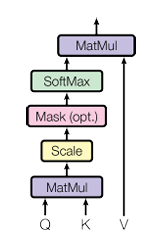

</center>

It is given by the formula 
$$
Attention (Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})
$$ 

 where $Q, K, \& V$ 
 represent the query, key and value matrices respectively.  $d_k$ represent the dimension associated with key.

Let's discover more about individual tokens/words. Let $x_i$ represent the input tokens. We convert the input vector to

1. Query Vector: $q = W_q*x_i$; where $W_q$ represent the trainable-weight matrix corresponding to query. 
2. Key Vector: $k = W_k*x_i$; where $W_k$ represent the trainable-weight matrix corresponding to key. 
3. Value vector: $v = W_v*x_i$; where $W_v$ represent the trainable-weight matrix corresponding to value. 

In [ ]:

class Attention(nn.Module):
    """Perform Self-Attention Operation"""
    def __init__(self,query_shape,key_shape,value_shape, model_size=512):
        super().__init__()
        self.d_q= query_shape[-1]
        self.d_k = key_shape[-1]
        self.d_v = value_shape[-1]
        self.model_size = model_size

        # Trainable-weight matrix corresponding to query.
        self.W_q= nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty((self.d_q, self.model_size))))
        # Trainable-weight matrix corresponding to key.
        self.W_k= nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty((self.d_k, self.model_size))))
        # Trainable-weight matrix corresponding to value.
        self.W_v= nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty((self.d_v, self.model_size))))
        
        # Softmax Operation
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, query, key, value, attention_mask=None):
        """
        query: Input vector
        key: Input vector
        value: Input vector
        attention_mask: If attention_mask is not None, it represent masked attention
        """
        # Step 1a: We multiply input vector to  query trainble matrix to form query.
        query_t = torch.matmul(query, self.W_q)
        # Step 1b: We multiply input vector to  key trainble matrix to form key.
        key_t = torch.matmul(key, self.W_k)
        # Step 1c: We multiply input vector to  value trainble matrix to form value.
        value_t = torch.matmul(value, self.W_v)

        # Step 2: We perform Q*transpose(K)/sqrt(dimension of key)
        query_key=torch.matmul(query_t, key_t.transpose(-2,-1))/math.sqrt(self.d_k)

        # Step 3: We use this for masked-attention. 
        if attention_mask is not None:
            # This is mainly used for auto-regressive masking
            query_key = query_key.masked_fill(attention_mask.bool(), float('-inf'))
       
       # Step 4: Attention operation: query_key*value
        attention = torch.matmul(self.softmax(query_key), value_t)
        return attention


## Muti-Head Attention
<center>

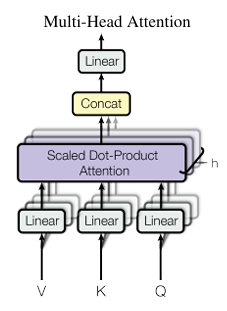

</center>
We project the key, query and value matrices in $h$-different directions or $h$ heads. These are concatenated and then projected once again.

$MultiHead (Q, K, V) = Concat(head_1, head_2, ...., head_h)W^O$

where $head_i = Attention(QW^q_i,KW^k_i,VW^v_i)$

In [ ]:
class MultiHeadAttention(nn.Module):
    """Perform Self-Attention Operation"""
    def __init__(self, query_shape,key_shape,value_shape, head_count, model_size=512):
        super(MultiHeadAttention,self).__init__()
        self.head_count = head_count
        self.model_size = model_size
        self.query_shape = query_shape
        self.key_shape = key_shape
        self.value_shape = value_shape

        # Output weight matrix projecttion
        self.W_O = nn.Parameter(nn.init.xavier_uniform_(torch.empty(self.head_count*self.value_shape[-1],self.model_size)))
        
        # Concatentate the attention heads to form multi-head attention
        self.heads = nn.ModuleList([
                                    Attention(self.query_shape, self.key_shape, self.value_shape, self.model_size) 
                                    for _ in range(self.head_count)
                                    ])

    def forward(self, query, key, value, attention_mask =None):
        """
        query: Input vector
        key: Input vector
        value: Input vector
        attention_mask: If attention_mask is not None, it represent masked attention
        """
        # Step 1: Perform attention for query, key & value for each head and concatenate to form multi-heads. 
        mh_p1=torch.cat([head(query, key, value, attention_mask) for head in self.heads],-1)
        # Step 2: Multiply concatenated heads to output weight matrix
        mh_p2 = torch.matmul(mh_p1, self.W_O)
        return mh_p2

## Feed-forward Network

This is a fully connected feed-forward network applied to each position seperately and identically. There are 2 linear transformations

$$FFN(x) = max(0, xW_1+b_1)W_2 + b_2$$

In [ ]:
class FeedForwardNetwork(nn.Module):
    """Perform Feed-Forward Operation inside Encoder/Decoder Operations"""
    def __init__(self,input_dimension,output_dimension,hidden_dimension):
        super(FeedForwardNetwork,self).__init__()
        self.input_dimension = input_dimension
        self.output_dimension = output_dimension
        self.hidden_dimension = hidden_dimension
        self.linear_1 = nn.Linear(self.input_dimension,self.hidden_dimension)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(self.hidden_dimension,self.output_dimension)

    def forward(self,x):
        """
        x: Input vector
        """
        # Step 1: Perform  max(0,xW1 +b1)W2
        layer_1 = self.relu(self.linear_1(x))
        # Step 2: FFN(x) = max(0,xW1 +b1)W2 +b2
        layer_2 = self.relu(self.linear_2(layer_1))
        return layer_2

## Encoder

<center>

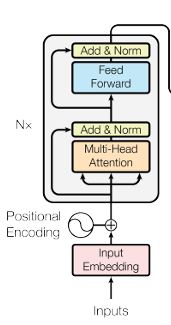

</center>
Encoder has 2 sub-layers.

1. SubLayer 1: Multi-head self-attention mechanism. 
2. SubLayer 2: Feed-forward Network

Both the sub-layers are connected with residual connection followed by layer-normalization. Mathematically, it is given by

$$LayerNorm(x+SubLayer(x))$$

In [ ]:
class Encoder(nn.Module):
    """Transformer Encoder Layer"""
    def __init__(self,query_shape,key_shape,value_shape,head_count,model_size,ffn_hidden_dimension,dropout_rate):
        super().__init__()
        self.query_shape = query_shape
        self.key_shape = key_shape
        self.value_shape = value_shape
        self.head_count = head_count
        self.model_size = model_size
        self.ffn_hidden_dimension = ffn_hidden_dimension
        self.multi_head = MultiHeadAttention(self.query_shape,
                                             self.key_shape,
                                             self.value_shape,
                                             self.head_count,
                                             self.model_size)
        self.normal_layer_1 = nn.LayerNorm(self.model_size)
        self.normal_layer_2 = nn.LayerNorm(self.model_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.ffn = FeedForwardNetwork(self.model_size,self.model_size,self.ffn_hidden_dimension)
    
    def forward(self,x):
        """
        x: Positional Embedding of input + Embedding of input
        """

        x_input = x

        # Sub-Layer 1
        # Step 1: Multi-head attention
        multi_head_output = self.multi_head(x_input,x_input,x_input)
        # Step 2: Residual Operation + Layer Normalization
        layer_norm_1_output = self.normal_layer_1(x_input + self.dropout(multi_head_output))

        # Sub-Layer 2
        # Step 3: Feed-forward network
        ffn_output = self.ffn(layer_norm_1_output)
        # Step 4: Residual Operation + Layer Normalization
        encoder_output = self.normal_layer_2(layer_norm_1_output + self.dropout(ffn_output))
        
        return encoder_output

## Decoder

<CENTER>

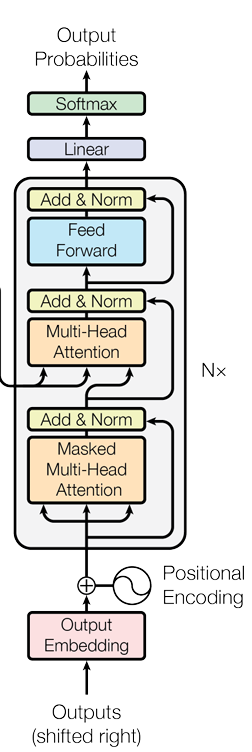

</CENTER>


Decoder has 3 sub-layers. 

1. SubLayer 1: Masked Multi-head attention
2. SubLayer 2: Multi-head attention
3. SubLayer 3: Feed-forward Network

The sub-layers are connected with residual connection followed by layer-normalization. Mathematically, it is given by

$$LayerNorm(x+SubLayer(x))$$

Masked multi-head attention is to ensure that the previous steps of the output are only looked and future steps of output aren't looked while performing attention mechanism. In other words, we want the decoder to have auto-regressive property. As a part of masking we give the value to mask as $-\infty$. 

For the multi-head attention, value & key vectors are the outputs of the encoder block.

In [ ]:
class Decoder(nn.Module):
    """Transformer Decoder Layer"""
    def __init__(self,query_shape,key_shape,value_shape,head_count,model_size,ffn_hidden_dimension,dropout_rate):
        super().__init__()
        self.query_shape = query_shape
        self.key_shape = key_shape
        self.value_shape = value_shape
        self.head_count = head_count
        self.model_size = model_size
        self.ffn_hidden_dimension = ffn_hidden_dimension
        self.multi_head = MultiHeadAttention(self.query_shape,
                                             self.key_shape,
                                             self.value_shape,
                                             self.head_count,
                                             self.model_size)
        self.masked_multi_head = MultiHeadAttention(self.query_shape,
                                             self.key_shape,
                                             self.value_shape,
                                             self.head_count,
                                             self.model_size)
        self.normal_layer_1 = nn.LayerNorm(self.model_size)
        self.normal_layer_2 = nn.LayerNorm(self.model_size)
        self.normal_layer_3 = nn.LayerNorm(self.model_size)
        self.ffn = FeedForwardNetwork(self.model_size,self.model_size,
                                         self.ffn_hidden_dimension)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self,x, encoder_output):
        """
        x: Positional Embedding of output + Embedding of output
        encoder_output: Output of the encoder
        """

        # Step 1:
        # Masked Multi-Head Attention: 
        # This is mainly used to prevent overlooking for futuristic values or predictions of the output. 
        x_input = x
        decoder_ip_sentence_length = x_input.shape[-2]
        mask = torch.triu(torch.ones((decoder_ip_sentence_length,
                                      decoder_ip_sentence_length),
                                      device=x.device),diagonal=1)

        masked_attention = self.masked_multi_head(x_input,x_input,x_input,attention_mask = mask)
        layer_norm_1_output = self.normal_layer_1(x_input + self.dropout(masked_attention))

        # Step 2:
        # Multi-Head Attention: 
        # This is mainly used to prevent overlooking for futuristic values or predictions of the output. 
        # Query-> Decoder based 
        # Key-> From the output of encoder
        # Value-> From the output of encoder
        multi_head_attention = self.multi_head(layer_norm_1_output,encoder_output,encoder_output)
        layer_norm_2_output = self.normal_layer_2(layer_norm_1_output + self.dropout(multi_head_attention))

        # Step 3: Feed-forward Network
        decoder_output = self.normal_layer_3(layer_norm_2_output + self.ffn(layer_norm_2_output))
        return decoder_output


## Embeddings

<CENTER>

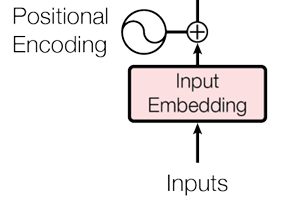

</CENTER>

In embedding layers, we multiply the weights by $\sqrt{d_{model}}$. 

**Positional Encoding:** Positional encodings are added to make the model position-aware especially since it is a natural langauge where order of words or sequences matters. 

The positional encoding used is

$PE_{(pos,2i)} = sin(\frac{pos}{10000^{\frac{2i}{d_{model}}}})$
$PE_{(pos,2i+1)} = cos(\frac{pos}{10000^{\frac{2i}{d_{model}}}})$


The dimension of embeddings and position-embeddings are the same and they are added.

In [21]:
import torch
import torch.nn as nn
import math

class TransformerEmbedding(nn.Module):
    """Token embeddings for the transformer."""
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        nn.init.uniform_(self.embedding.weight, a=-0.1, b=0.1)
        self.embedding_dim = embedding_dim

    def forward(self, x):
        # Scale embeddings by sqrt(d_model)
        return math.sqrt(self.embedding_dim) * self.embedding(x)

class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding."""
    def __init__(self, embedding_dim, max_len=5000, wavelength=10000.):
        super().__init__()
        # Create positional encoding matrix [1, max_len, embedding_dim]
        pe = torch.zeros(max_len, embedding_dim)
        position = torch.arange(0, max_len).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(
            torch.arange(0, embedding_dim, 2) * (-math.log(wavelength) / embedding_dim)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, embedding_dim]
        self.register_buffer('pe', pe)  # not a parameter, moves to device automatically

    def forward(self, x):
        seq_len = x.size(1)  # x is [batch_size, seq_len]
        return self.pe[:, :seq_len, :]

class ModelEmbeddings(nn.Module):
    """Combined token + positional embeddings with dropout."""
    def __init__(self, vocab_size, embedding_dim, dropout_rate=0.1, max_len=5000):
        super().__init__()
        self.token_emb = TransformerEmbedding(vocab_size, embedding_dim)
        self.pos_emb = PositionalEncoding(embedding_dim, max_len=max_len)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # x: [batch_size, seq_len]
        embeddings = self.token_emb(x) + self.pos_emb(x)
        return self.dropout(embeddings)

## Encoder-Decoder

<CENTER>

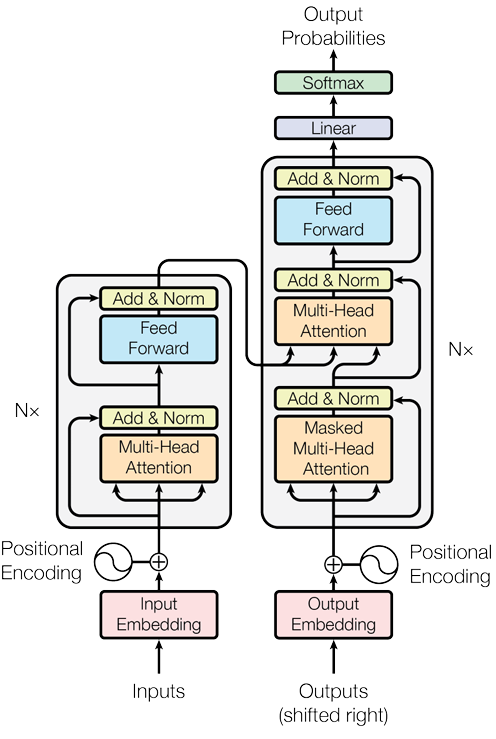

</CENTER>

In [ ]:
class EncoderDecoderTransformer(nn.Module):
    """
    Encoder-Decoder Transformer: Main Block
    """
    def __init__(self, num_layers, source_vocab_size, target_vocab_size, query_shape, key_shape, value_shape, head_count, model_size, ffn_hidden_dimension, dropout_rate):
        super().__init__()
        self.encoder_layers = nn.ModuleList([Encoder(query_shape, 
                                key_shape, 
                                value_shape, 
                                head_count, 
                                model_size, 
                                ffn_hidden_dimension, 
                                dropout_rate) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([Decoder(query_shape, 
                               key_shape, 
                               value_shape, 
                               head_count, 
                               model_size, 
                               ffn_hidden_dimension, 
                               dropout_rate) for _ in range(num_layers)])
        self.embeddings_ip = ModelEmbeddings(source_vocab_size,model_size,dropout_rate)
        self.embeddings_op = ModelEmbeddings(target_vocab_size,model_size,dropout_rate)

        self.ffn = nn.Linear(model_size,target_vocab_size)
    
    def forward(self,input_text,output_text):
        """
        input_text: Input text
        output_text: Output text
        """
        # Step 1: Get the embeddings (Embeddings + Positional Embedding) of input and output
        ip_embedding = self.embeddings_ip(input_text)
        op_embedding = self.embeddings_ip(output_text)

        # Step 2: Encoder Layer
        encoder_output = ip_embedding
        for encoder in self.encoder_layers:
            encoder_output = encoder(ip_embedding)
        
        # Step 3: Decoder Layer
        decoder_output = op_embedding
        for decoder in self.decoder_layers:
            decoder_output = decoder(op_embedding, encoder_output)

        output = self.ffn(decoder_output)

        return output

In [23]:
model = EncoderDecoderTransformer(num_layers=6, 
                                  source_vocab_size=vocab_size, target_vocab_size=vocab_size, 
                                  query_shape=(128,), key_shape=(128,), value_shape=(128,), 
                                  head_count=4, model_size=128, ffn_hidden_dimension=128, 
                                  dropout_rate=0.01)
model.to(DEVICE)

EncoderDecoderTransformer(
  (encoder_layers): ModuleList(
    (0-5): 6 x Encoder(
      (multi_head): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Attention(
            (softmax): Softmax(dim=-1)
          )
        )
      )
      (normal_layer_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (normal_layer_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.01, inplace=False)
      (ffn): FeedForwardNetwork(
        (linear_1): Linear(in_features=128, out_features=128, bias=True)
        (relu): ReLU()
        (linear_2): Linear(in_features=128, out_features=128, bias=True)
      )
    )
  )
  (decoder_layers): ModuleList(
    (0-5): 6 x Decoder(
      (multi_head): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Attention(
            (softmax): Softmax(dim=-1)
          )
        )
      )
      (masked_multi_head): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x 

# Training

In [ ]:
# wrap with torch dataloader for training
batch_size = 64
train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, drop_last=True, batch_size=batch_size)
valid_dataloader = DataLoader(tokenized_datasets['validation'], batch_size=batch_size)

In [ ]:
# define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_fn =  torch.nn.CrossEntropyLoss(ignore_index=fast_tok.pad_token_id)

In [ ]:
batch_size = 64
train_dataloader = DataLoader(
    tokenized_datasets['train'], 
    shuffle=True, 
    drop_last=True, 
    batch_size=batch_size
)
valid_dataloader = DataLoader(
    tokenized_datasets['validation'], 
    shuffle=False,
    drop_last=True,
    batch_size=batch_size
)

# Get vocab size from tokenizer
vocab_size = len(fast_tok)

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 14,747,560
Trainable parameters: 14,747,560


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=fast_tok.pad_token_id)

# Optional: Learning rate scheduler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

In [ ]:
def train_one_epoch(epoch_num):
    """Training function for one epoch"""
    running_loss = 0.
    num_batches = len(train_dataloader)

    for i, data in tqdm(enumerate(train_dataloader), total=num_batches, desc=f"Epoch {epoch_num} [Train]"):
        inputs = data['input_ids'].to(DEVICE)
        labels = data['labels'].to(DEVICE)
        
        # For causal language modeling with encoder-decoder:
        # This makes the model learn to reconstruct the input
        decoder_input = inputs
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs, decoder_input)
        
        # Reshape for CrossEntropyLoss: (batch * seq_len, vocab_size) and (batch * seq_len)
        loss = loss_fn(outputs.view(-1, vocab_size), labels.view(-1))
        
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()

        if (i + 1) % 100 == 0:
            avg_loss_so_far = running_loss / (i + 1)
            print(f'  Step {i + 1}/{num_batches} - Avg loss: {avg_loss_so_far:.4f}, Current loss: {loss.item():.4f}')

    # Return average loss for the entire epoch
    avg_loss = running_loss / num_batches
    return avg_loss

In [ ]:
def validate():
    """Validation function"""
    running_vloss = 0.0
    num_batches = len(valid_dataloader)
    
    model.eval()
    
    with torch.no_grad():
        for i, vdata in tqdm(enumerate(valid_dataloader), total=num_batches, desc="Validation"):
            vinputs = vdata['input_ids'].to(DEVICE)
            vlabels = vdata['labels'].to(DEVICE)
            
            # Same decoder input strategy as training
            decoder_input = vinputs
            
            voutputs = model(vinputs, decoder_input)
            
            vloss = loss_fn(voutputs.view(-1, vocab_size), vlabels.view(-1))
            running_vloss += vloss.item()
    
    avg_vloss = running_vloss / num_batches
    return avg_vloss


def calculate_perplexity(loss):
    """Calculate perplexity from loss"""
    return torch.exp(torch.tensor(loss)).item()


In [1]:
import os
os.getcwd()

'/home/thejussk/transformer-scratch'

In [ ]:
EPOCHS = 1 # TinyStories typically needs 2-5 epochs
best_vloss = float('inf')

print(f"\nStarting training on TinyStories dataset...")
print(f"Training samples: {len(tokenized_datasets['train']):,}")
print(f"Validation samples: {len(tokenized_datasets['validation']):,}")
print(f"Batch size: {batch_size}")
print(f"Steps per epoch: {len(train_dataloader):,}\n")

for epoch in range(EPOCHS):
    print(f'\n{"="*70}')
    print(f'EPOCH {epoch + 1}/{EPOCHS}')
    print(f'{"="*70}')

    # Train model
    model.train()
    avg_loss = train_one_epoch(epoch + 1)
    train_perplexity = calculate_perplexity(avg_loss)
    
    print(f'\n✓ Training complete')
    print(f'  Average Loss: {avg_loss:.4f}')
    print(f'  Perplexity: {train_perplexity:.2f}')

    # Validation
    print('\nRunning validation...')
    avg_vloss = validate()
    val_perplexity = calculate_perplexity(avg_vloss)
    
    # Update learning rate scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f'\n{"="*70}')
    print(f'EPOCH {epoch + 1} SUMMARY:')
    print(f'  Training Loss:       {avg_loss:.4f}  (Perplexity: {train_perplexity:.2f})')
    print(f'  Validation Loss:     {avg_vloss:.4f}  (Perplexity: {val_perplexity:.2f})')
    print(f'  Learning Rate:       {current_lr:.6f}')
    print(f'{"="*70}')
    
    # Save best model
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_loss,
            'val_loss': avg_vloss,
            'train_perplexity': train_perplexity,
            'val_perplexity': val_perplexity,
        }, 'best_tinystories_model.pth')
        print(f'✓ Saved new best model (val_loss: {best_vloss:.4f}, perplexity: {val_perplexity:.2f})')
    
    # Save checkpoint every epoch
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_loss,
        'val_loss': avg_vloss,
    }, f'checkpoint_epoch_{epoch + 1}.pth')



Starting training on TinyStories dataset...
Training samples: 4,741,600
Validation samples: 48,149
Batch size: 64
Steps per epoch: 74,087


EPOCH 1/1


Epoch 1 [Train]:   0%|          | 0/74087 [00:00<?, ?it/s]

Epoch 1 [Train]:   0%|          | 100/74087 [00:33<10:27:05,  1.97it/s]

  Step 100/74087 - Avg loss: 8.8418, Current loss: 7.7956


Epoch 1 [Train]:   0%|          | 200/74087 [01:24<25:20:28,  1.23s/it]

  Step 200/74087 - Avg loss: 7.9060, Current loss: 6.2565


Epoch 1 [Train]:   0%|          | 300/74087 [02:12<6:07:46,  3.34it/s] 

  Step 300/74087 - Avg loss: 7.2287, Current loss: 5.5428


Epoch 1 [Train]:   1%|          | 400/74087 [02:52<6:40:44,  3.06it/s] 

  Step 400/74087 - Avg loss: 6.7598, Current loss: 5.1528


Epoch 1 [Train]:   1%|          | 500/74087 [03:19<4:24:49,  4.63it/s]

  Step 500/74087 - Avg loss: 6.4096, Current loss: 4.8680


Epoch 1 [Train]:   1%|          | 600/74087 [03:44<5:24:53,  3.77it/s]

  Step 600/74087 - Avg loss: 6.1307, Current loss: 4.5346


Epoch 1 [Train]:   1%|          | 700/74087 [04:30<5:38:13,  3.62it/s] 

  Step 700/74087 - Avg loss: 5.8966, Current loss: 4.3606


Epoch 1 [Train]:   1%|          | 800/74087 [04:52<3:55:25,  5.19it/s]

  Step 800/74087 - Avg loss: 5.6920, Current loss: 4.1319


Epoch 1 [Train]:   1%|          | 900/74087 [05:16<5:27:34,  3.72it/s]

  Step 900/74087 - Avg loss: 5.5013, Current loss: 3.7483


Epoch 1 [Train]:   1%|▏         | 1000/74087 [05:46<4:05:55,  4.95it/s]

  Step 1000/74087 - Avg loss: 5.3130, Current loss: 3.4131


Epoch 1 [Train]:   1%|▏         | 1100/74087 [06:15<4:47:13,  4.24it/s] 

  Step 1100/74087 - Avg loss: 5.1231, Current loss: 3.0421


Epoch 1 [Train]:   2%|▏         | 1201/74087 [06:36<3:48:59,  5.30it/s]

  Step 1200/74087 - Avg loss: 4.9277, Current loss: 2.5378


Epoch 1 [Train]:   2%|▏         | 1300/74087 [07:11<12:41:25,  1.59it/s]

  Step 1300/74087 - Avg loss: 4.7293, Current loss: 2.0955


Epoch 1 [Train]:   2%|▏         | 1400/74087 [07:36<4:26:10,  4.55it/s] 

  Step 1400/74087 - Avg loss: 4.5303, Current loss: 1.6982


Epoch 1 [Train]:   2%|▏         | 1500/74087 [07:58<4:08:46,  4.86it/s]

  Step 1500/74087 - Avg loss: 4.3347, Current loss: 1.3864


Epoch 1 [Train]:   2%|▏         | 1601/74087 [08:18<3:17:20,  6.12it/s] 

  Step 1600/74087 - Avg loss: 4.1474, Current loss: 1.3004


Epoch 1 [Train]:   2%|▏         | 1701/74087 [08:37<3:32:42,  5.67it/s]

  Step 1700/74087 - Avg loss: 3.9698, Current loss: 0.9804


Epoch 1 [Train]:   2%|▏         | 1800/74087 [09:00<4:23:47,  4.57it/s]

  Step 1800/74087 - Avg loss: 3.8031, Current loss: 0.8543


Epoch 1 [Train]:   3%|▎         | 1901/74087 [09:33<3:47:42,  5.28it/s] 

  Step 1900/74087 - Avg loss: 3.6474, Current loss: 0.8444


Epoch 1 [Train]:   3%|▎         | 2000/74087 [09:55<4:10:16,  4.80it/s] 

  Step 2000/74087 - Avg loss: 3.5020, Current loss: 0.6809


Epoch 1 [Train]:   3%|▎         | 2101/74087 [10:12<3:17:18,  6.08it/s]

  Step 2100/74087 - Avg loss: 3.3667, Current loss: 0.6131


Epoch 1 [Train]:   3%|▎         | 2201/74087 [10:31<2:56:15,  6.80it/s] 

  Step 2200/74087 - Avg loss: 3.2406, Current loss: 0.4725


Epoch 1 [Train]:   3%|▎         | 2301/74087 [10:46<3:04:43,  6.48it/s]

  Step 2300/74087 - Avg loss: 3.1231, Current loss: 0.5454


Epoch 1 [Train]:   3%|▎         | 2401/74087 [11:16<10:40:55,  1.86it/s]

  Step 2400/74087 - Avg loss: 3.0132, Current loss: 0.4833


Epoch 1 [Train]:   3%|▎         | 2500/74087 [11:46<3:23:00,  5.88it/s] 

  Step 2500/74087 - Avg loss: 2.9103, Current loss: 0.4433


Epoch 1 [Train]:   4%|▎         | 2601/74087 [12:04<3:10:59,  6.24it/s]

  Step 2600/74087 - Avg loss: 2.8140, Current loss: 0.4193


Epoch 1 [Train]:   4%|▎         | 2701/74087 [12:32<3:29:17,  5.68it/s] 

  Step 2700/74087 - Avg loss: 2.7237, Current loss: 0.3558


Epoch 1 [Train]:   4%|▍         | 2801/74087 [12:51<3:14:00,  6.12it/s]

  Step 2800/74087 - Avg loss: 2.6390, Current loss: 0.3203


Epoch 1 [Train]:   4%|▍         | 2901/74087 [13:07<3:20:08,  5.93it/s]

  Step 2900/74087 - Avg loss: 2.5592, Current loss: 0.2970


Epoch 1 [Train]:   4%|▍         | 3001/74087 [13:23<3:17:46,  5.99it/s]

  Step 3000/74087 - Avg loss: 2.4839, Current loss: 0.3333


Epoch 1 [Train]:   4%|▍         | 3101/74087 [13:39<3:06:24,  6.35it/s]

  Step 3100/74087 - Avg loss: 2.4128, Current loss: 0.2605


Epoch 1 [Train]:   4%|▍         | 3201/74087 [13:57<2:54:55,  6.75it/s] 

  Step 3200/74087 - Avg loss: 2.3457, Current loss: 0.2351


Epoch 1 [Train]:   4%|▍         | 3301/74087 [14:16<2:54:03,  6.78it/s] 

  Step 3300/74087 - Avg loss: 2.2819, Current loss: 0.2267


Epoch 1 [Train]:   5%|▍         | 3401/74087 [14:50<2:49:10,  6.96it/s] 

  Step 3400/74087 - Avg loss: 2.2217, Current loss: 0.2255


Epoch 1 [Train]:   5%|▍         | 3501/74087 [15:04<2:46:56,  7.05it/s]

  Step 3500/74087 - Avg loss: 2.1646, Current loss: 0.2207


Epoch 1 [Train]:   5%|▍         | 3601/74087 [15:18<2:44:25,  7.14it/s]

  Step 3600/74087 - Avg loss: 2.1101, Current loss: 0.1792


Epoch 1 [Train]:   5%|▍         | 3701/74087 [15:32<2:54:12,  6.73it/s]

  Step 3700/74087 - Avg loss: 2.0585, Current loss: 0.2252


Epoch 1 [Train]:   5%|▌         | 3801/74087 [15:47<2:53:58,  6.73it/s]

  Step 3800/74087 - Avg loss: 2.0093, Current loss: 0.1535


Epoch 1 [Train]:   5%|▌         | 3901/74087 [16:02<2:50:44,  6.85it/s]

  Step 3900/74087 - Avg loss: 1.9624, Current loss: 0.1678


Epoch 1 [Train]:   5%|▌         | 4001/74087 [16:17<2:47:44,  6.96it/s]

  Step 4000/74087 - Avg loss: 1.9177, Current loss: 0.1833


Epoch 1 [Train]:   6%|▌         | 4101/74087 [16:31<2:50:25,  6.84it/s]

  Step 4100/74087 - Avg loss: 1.8749, Current loss: 0.1922


Epoch 1 [Train]:   6%|▌         | 4201/74087 [16:45<2:41:12,  7.23it/s]

  Step 4200/74087 - Avg loss: 1.8341, Current loss: 0.1588


Epoch 1 [Train]:   6%|▌         | 4301/74087 [16:59<2:38:21,  7.34it/s]

  Step 4300/74087 - Avg loss: 1.7950, Current loss: 0.1612


Epoch 1 [Train]:   6%|▌         | 4401/74087 [17:13<2:42:09,  7.16it/s]

  Step 4400/74087 - Avg loss: 1.7575, Current loss: 0.1247


Epoch 1 [Train]:   6%|▌         | 4501/74087 [17:27<2:36:45,  7.40it/s]

  Step 4500/74087 - Avg loss: 1.7217, Current loss: 0.1389


Epoch 1 [Train]:   6%|▌         | 4601/74087 [17:41<2:36:46,  7.39it/s]

  Step 4600/74087 - Avg loss: 1.6872, Current loss: 0.0993


Epoch 1 [Train]:   6%|▋         | 4701/74087 [17:55<3:11:40,  6.03it/s]

  Step 4700/74087 - Avg loss: 1.6542, Current loss: 0.0986


Epoch 1 [Train]:   6%|▋         | 4801/74087 [18:09<2:41:53,  7.13it/s]

  Step 4800/74087 - Avg loss: 1.6224, Current loss: 0.1139


Epoch 1 [Train]:   7%|▋         | 4901/74087 [18:23<3:14:56,  5.92it/s]

  Step 4900/74087 - Avg loss: 1.5918, Current loss: 0.0968


Epoch 1 [Train]:   7%|▋         | 5001/74087 [18:38<2:46:19,  6.92it/s]

  Step 5000/74087 - Avg loss: 1.5624, Current loss: 0.1116


Epoch 1 [Train]:   7%|▋         | 5101/74087 [18:52<2:41:11,  7.13it/s]

  Step 5100/74087 - Avg loss: 1.5341, Current loss: 0.1179


Epoch 1 [Train]:   7%|▋         | 5201/74087 [19:06<2:43:04,  7.04it/s]

  Step 5200/74087 - Avg loss: 1.5068, Current loss: 0.1234


Epoch 1 [Train]:   7%|▋         | 5301/74087 [19:20<2:41:19,  7.11it/s]

  Step 5300/74087 - Avg loss: 1.4805, Current loss: 0.1135


Epoch 1 [Train]:   7%|▋         | 5401/74087 [19:35<2:42:47,  7.03it/s]

  Step 5400/74087 - Avg loss: 1.4551, Current loss: 0.1049


Epoch 1 [Train]:   7%|▋         | 5501/74087 [19:50<2:47:02,  6.84it/s]

  Step 5500/74087 - Avg loss: 1.4305, Current loss: 0.0772


Epoch 1 [Train]:   8%|▊         | 5601/74087 [20:04<2:42:44,  7.01it/s]

  Step 5600/74087 - Avg loss: 1.4068, Current loss: 0.0989


Epoch 1 [Train]:   8%|▊         | 5701/74087 [20:18<2:38:55,  7.17it/s]

  Step 5700/74087 - Avg loss: 1.3839, Current loss: 0.1002


Epoch 1 [Train]:   8%|▊         | 5801/74087 [20:32<2:38:18,  7.19it/s]

  Step 5800/74087 - Avg loss: 1.3617, Current loss: 0.0930


Epoch 1 [Train]:   8%|▊         | 5901/74087 [20:46<2:41:52,  7.02it/s]

  Step 5900/74087 - Avg loss: 1.3403, Current loss: 0.0988


Epoch 1 [Train]:   8%|▊         | 6001/74087 [21:00<2:47:42,  6.77it/s]

  Step 6000/74087 - Avg loss: 1.3195, Current loss: 0.0980


Epoch 1 [Train]:   8%|▊         | 6101/74087 [21:14<2:39:09,  7.12it/s]

  Step 6100/74087 - Avg loss: 1.2994, Current loss: 0.1036


Epoch 1 [Train]:   8%|▊         | 6201/74087 [21:28<2:40:24,  7.05it/s]

  Step 6200/74087 - Avg loss: 1.2799, Current loss: 0.0733


Epoch 1 [Train]:   9%|▊         | 6301/74087 [21:42<2:36:14,  7.23it/s]

  Step 6300/74087 - Avg loss: 1.2610, Current loss: 0.0804


Epoch 1 [Train]:   9%|▊         | 6401/74087 [21:56<2:37:52,  7.15it/s]

  Step 6400/74087 - Avg loss: 1.2427, Current loss: 0.1131


Epoch 1 [Train]:   9%|▉         | 6501/74087 [22:10<2:38:15,  7.12it/s]

  Step 6500/74087 - Avg loss: 1.2249, Current loss: 0.0846


Epoch 1 [Train]:   9%|▉         | 6601/74087 [22:24<2:32:16,  7.39it/s]

  Step 6600/74087 - Avg loss: 1.2076, Current loss: 0.0935


Epoch 1 [Train]:   9%|▉         | 6701/74087 [22:38<2:38:42,  7.08it/s]

  Step 6700/74087 - Avg loss: 1.1908, Current loss: 0.1000


Epoch 1 [Train]:   9%|▉         | 6801/74087 [22:52<2:52:39,  6.50it/s]

  Step 6800/74087 - Avg loss: 1.1745, Current loss: 0.0826


Epoch 1 [Train]:   9%|▉         | 6901/74087 [23:07<2:45:27,  6.77it/s]

  Step 6900/74087 - Avg loss: 1.1587, Current loss: 0.0696


Epoch 1 [Train]:   9%|▉         | 7001/74087 [23:22<2:44:13,  6.81it/s]

  Step 7000/74087 - Avg loss: 1.1432, Current loss: 0.1049


Epoch 1 [Train]:  10%|▉         | 7101/74087 [23:36<2:37:36,  7.08it/s]

  Step 7100/74087 - Avg loss: 1.1282, Current loss: 0.0657


Epoch 1 [Train]:  10%|▉         | 7201/74087 [23:50<2:44:41,  6.77it/s]

  Step 7200/74087 - Avg loss: 1.1136, Current loss: 0.0628


Epoch 1 [Train]:  10%|▉         | 7301/74087 [24:05<2:38:26,  7.02it/s]

  Step 7300/74087 - Avg loss: 1.0994, Current loss: 0.0902


Epoch 1 [Train]:  10%|▉         | 7401/74087 [24:20<2:38:11,  7.03it/s]

  Step 7400/74087 - Avg loss: 1.0855, Current loss: 0.0747


Epoch 1 [Train]:  10%|█         | 7501/74087 [24:34<2:36:32,  7.09it/s]

  Step 7500/74087 - Avg loss: 1.0721, Current loss: 0.0775


Epoch 1 [Train]:  10%|█         | 7601/74087 [24:48<2:36:33,  7.08it/s]

  Step 7600/74087 - Avg loss: 1.0589, Current loss: 0.0775


Epoch 1 [Train]:  10%|█         | 7701/74087 [25:04<3:13:30,  5.72it/s]

  Step 7700/74087 - Avg loss: 1.0460, Current loss: 0.0639


Epoch 1 [Train]:  11%|█         | 7801/74087 [25:21<2:48:26,  6.56it/s]

  Step 7800/74087 - Avg loss: 1.0335, Current loss: 0.0759


Epoch 1 [Train]:  11%|█         | 7901/74087 [25:36<3:04:05,  5.99it/s]

  Step 7900/74087 - Avg loss: 1.0213, Current loss: 0.0630


Epoch 1 [Train]:  11%|█         | 8001/74087 [25:53<2:52:46,  6.38it/s]

  Step 8000/74087 - Avg loss: 1.0093, Current loss: 0.0583


Epoch 1 [Train]:  11%|█         | 8101/74087 [26:08<2:44:35,  6.68it/s]

  Step 8100/74087 - Avg loss: 0.9977, Current loss: 0.0723


Epoch 1 [Train]:  11%|█         | 8201/74087 [26:24<2:41:50,  6.78it/s]

  Step 8200/74087 - Avg loss: 0.9864, Current loss: 0.0457


Epoch 1 [Train]:  11%|█         | 8301/74087 [26:39<2:45:58,  6.61it/s]

  Step 8300/74087 - Avg loss: 0.9753, Current loss: 0.0905


Epoch 1 [Train]:  11%|█▏        | 8401/74087 [26:53<2:33:42,  7.12it/s]

  Step 8400/74087 - Avg loss: 0.9644, Current loss: 0.0777


Epoch 1 [Train]:  11%|█▏        | 8501/74087 [27:07<2:33:14,  7.13it/s]

  Step 8500/74087 - Avg loss: 0.9538, Current loss: 0.0562


Epoch 1 [Train]:  12%|█▏        | 8601/74087 [27:22<2:32:53,  7.14it/s]

  Step 8600/74087 - Avg loss: 0.9434, Current loss: 0.0479


Epoch 1 [Train]:  12%|█▏        | 8701/74087 [27:37<2:32:30,  7.15it/s]

  Step 8700/74087 - Avg loss: 0.9333, Current loss: 0.0660


Epoch 1 [Train]:  12%|█▏        | 8801/74087 [27:51<2:27:22,  7.38it/s]

  Step 8800/74087 - Avg loss: 0.9234, Current loss: 0.0575


Epoch 1 [Train]:  12%|█▏        | 8901/74087 [28:05<2:26:58,  7.39it/s]

  Step 8900/74087 - Avg loss: 0.9137, Current loss: 0.0655


Epoch 1 [Train]:  12%|█▏        | 9001/74087 [28:19<2:28:19,  7.31it/s]

  Step 9000/74087 - Avg loss: 0.9042, Current loss: 0.0413


Epoch 1 [Train]:  12%|█▏        | 9101/74087 [28:33<2:27:37,  7.34it/s]

  Step 9100/74087 - Avg loss: 0.8950, Current loss: 0.0433


Epoch 1 [Train]:  12%|█▏        | 9201/74087 [28:47<2:26:35,  7.38it/s]

  Step 9200/74087 - Avg loss: 0.8859, Current loss: 0.0614


Epoch 1 [Train]:  13%|█▎        | 9301/74087 [29:00<2:28:44,  7.26it/s]

  Step 9300/74087 - Avg loss: 0.8770, Current loss: 0.0546


Epoch 1 [Train]:  13%|█▎        | 9401/74087 [29:14<2:28:05,  7.28it/s]

  Step 9400/74087 - Avg loss: 0.8682, Current loss: 0.0664


Epoch 1 [Train]:  13%|█▎        | 9501/74087 [29:28<2:25:36,  7.39it/s]

  Step 9500/74087 - Avg loss: 0.8597, Current loss: 0.0511


Epoch 1 [Train]:  13%|█▎        | 9601/74087 [29:41<2:26:04,  7.36it/s]

  Step 9600/74087 - Avg loss: 0.8513, Current loss: 0.0648


Epoch 1 [Train]:  13%|█▎        | 9701/74087 [29:55<2:27:16,  7.29it/s]

  Step 9700/74087 - Avg loss: 0.8431, Current loss: 0.0579


Epoch 1 [Train]:  13%|█▎        | 9801/74087 [30:09<2:25:08,  7.38it/s]

  Step 9800/74087 - Avg loss: 0.8351, Current loss: 0.0469


Epoch 1 [Train]:  13%|█▎        | 9901/74087 [30:22<2:26:18,  7.31it/s]

  Step 9900/74087 - Avg loss: 0.8272, Current loss: 0.0585


Epoch 1 [Train]:  13%|█▎        | 10001/74087 [30:36<2:24:15,  7.40it/s]

  Step 10000/74087 - Avg loss: 0.8194, Current loss: 0.0464


Epoch 1 [Train]:  14%|█▎        | 10101/74087 [30:50<2:27:15,  7.24it/s]

  Step 10100/74087 - Avg loss: 0.8119, Current loss: 0.0491


Epoch 1 [Train]:  14%|█▍        | 10201/74087 [31:04<2:28:28,  7.17it/s]

  Step 10200/74087 - Avg loss: 0.8044, Current loss: 0.0589


Epoch 1 [Train]:  14%|█▍        | 10301/74087 [31:18<2:25:07,  7.33it/s]

  Step 10300/74087 - Avg loss: 0.7971, Current loss: 0.0630


Epoch 1 [Train]:  14%|█▍        | 10401/74087 [31:32<2:29:16,  7.11it/s]

  Step 10400/74087 - Avg loss: 0.7899, Current loss: 0.0551


Epoch 1 [Train]:  14%|█▍        | 10501/74087 [31:46<2:25:10,  7.30it/s]

  Step 10500/74087 - Avg loss: 0.7829, Current loss: 0.0461


Epoch 1 [Train]:  14%|█▍        | 10601/74087 [32:00<2:23:48,  7.36it/s]

  Step 10600/74087 - Avg loss: 0.7760, Current loss: 0.0484


Epoch 1 [Train]:  14%|█▍        | 10701/74087 [32:14<2:31:39,  6.97it/s]

  Step 10700/74087 - Avg loss: 0.7692, Current loss: 0.0423


Epoch 1 [Train]:  15%|█▍        | 10801/74087 [32:28<2:24:03,  7.32it/s]

  Step 10800/74087 - Avg loss: 0.7625, Current loss: 0.0407


Epoch 1 [Train]:  15%|█▍        | 10901/74087 [32:42<2:24:41,  7.28it/s]

  Step 10900/74087 - Avg loss: 0.7560, Current loss: 0.0312


Epoch 1 [Train]:  15%|█▍        | 11001/74087 [32:56<2:22:46,  7.36it/s]

  Step 11000/74087 - Avg loss: 0.7495, Current loss: 0.0478


Epoch 1 [Train]:  15%|█▍        | 11101/74087 [33:09<2:26:02,  7.19it/s]

  Step 11100/74087 - Avg loss: 0.7432, Current loss: 0.0566


Epoch 1 [Train]:  15%|█▌        | 11201/74087 [33:24<2:28:54,  7.04it/s]

  Step 11200/74087 - Avg loss: 0.7370, Current loss: 0.0424


Epoch 1 [Train]:  15%|█▌        | 11301/74087 [33:38<2:44:15,  6.37it/s]

  Step 11300/74087 - Avg loss: 0.7309, Current loss: 0.0375


Epoch 1 [Train]:  15%|█▌        | 11401/74087 [33:54<2:39:31,  6.55it/s]

  Step 11400/74087 - Avg loss: 0.7249, Current loss: 0.0320


Epoch 1 [Train]:  16%|█▌        | 11501/74087 [34:09<2:33:02,  6.82it/s]

  Step 11500/74087 - Avg loss: 0.7190, Current loss: 0.0501


Epoch 1 [Train]:  16%|█▌        | 11601/74087 [34:27<3:17:44,  5.27it/s]

  Step 11600/74087 - Avg loss: 0.7132, Current loss: 0.0368


Epoch 1 [Train]:  16%|█▌        | 11701/74087 [34:46<2:38:18,  6.57it/s]

  Step 11700/74087 - Avg loss: 0.7075, Current loss: 0.0337


Epoch 1 [Train]:  16%|█▌        | 11801/74087 [35:01<2:28:26,  6.99it/s]

  Step 11800/74087 - Avg loss: 0.7019, Current loss: 0.0525


Epoch 1 [Train]:  16%|█▌        | 11901/74087 [35:15<2:25:12,  7.14it/s]

  Step 11900/74087 - Avg loss: 0.6963, Current loss: 0.0518


Epoch 1 [Train]:  16%|█▌        | 12001/74087 [35:30<2:24:48,  7.15it/s]

  Step 12000/74087 - Avg loss: 0.6909, Current loss: 0.0467


Epoch 1 [Train]:  16%|█▋        | 12101/74087 [35:43<2:21:29,  7.30it/s]

  Step 12100/74087 - Avg loss: 0.6856, Current loss: 0.0425


Epoch 1 [Train]:  16%|█▋        | 12201/74087 [35:57<2:28:53,  6.93it/s]

  Step 12200/74087 - Avg loss: 0.6803, Current loss: 0.0400


Epoch 1 [Train]:  17%|█▋        | 12301/74087 [36:11<2:22:44,  7.21it/s]

  Step 12300/74087 - Avg loss: 0.6752, Current loss: 0.0418


Epoch 1 [Train]:  17%|█▋        | 12401/74087 [36:25<2:16:43,  7.52it/s]

  Step 12400/74087 - Avg loss: 0.6701, Current loss: 0.0380


Epoch 1 [Train]:  17%|█▋        | 12501/74087 [36:39<2:19:52,  7.34it/s]

  Step 12500/74087 - Avg loss: 0.6650, Current loss: 0.0402


Epoch 1 [Train]:  17%|█▋        | 12601/74087 [36:53<2:24:13,  7.10it/s]

  Step 12600/74087 - Avg loss: 0.6601, Current loss: 0.0439


Epoch 1 [Train]:  17%|█▋        | 12701/74087 [37:07<2:19:50,  7.32it/s]

  Step 12700/74087 - Avg loss: 0.6552, Current loss: 0.0589


Epoch 1 [Train]:  17%|█▋        | 12801/74087 [37:21<2:22:11,  7.18it/s]

  Step 12800/74087 - Avg loss: 0.6505, Current loss: 0.0314


Epoch 1 [Train]:  17%|█▋        | 12901/74087 [37:35<2:19:32,  7.31it/s]

  Step 12900/74087 - Avg loss: 0.6457, Current loss: 0.0354


Epoch 1 [Train]:  18%|█▊        | 13001/74087 [37:49<2:30:18,  6.77it/s]

  Step 13000/74087 - Avg loss: 0.6411, Current loss: 0.0373


Epoch 1 [Train]:  18%|█▊        | 13101/74087 [38:03<2:32:20,  6.67it/s]

  Step 13100/74087 - Avg loss: 0.6365, Current loss: 0.0440


Epoch 1 [Train]:  18%|█▊        | 13201/74087 [38:17<2:18:08,  7.35it/s]

  Step 13200/74087 - Avg loss: 0.6320, Current loss: 0.0332


Epoch 1 [Train]:  18%|█▊        | 13301/74087 [38:31<2:19:09,  7.28it/s]

  Step 13300/74087 - Avg loss: 0.6275, Current loss: 0.0333


Epoch 1 [Train]:  18%|█▊        | 13401/74087 [38:45<2:23:09,  7.07it/s]

  Step 13400/74087 - Avg loss: 0.6232, Current loss: 0.0324


Epoch 1 [Train]:  18%|█▊        | 13501/74087 [38:59<2:21:50,  7.12it/s]

  Step 13500/74087 - Avg loss: 0.6188, Current loss: 0.0347


Epoch 1 [Train]:  18%|█▊        | 13601/74087 [39:13<2:16:02,  7.41it/s]

  Step 13600/74087 - Avg loss: 0.6146, Current loss: 0.0371


Epoch 1 [Train]:  18%|█▊        | 13701/74087 [39:27<2:16:35,  7.37it/s]

  Step 13700/74087 - Avg loss: 0.6104, Current loss: 0.0346


Epoch 1 [Train]:  19%|█▊        | 13801/74087 [39:40<2:21:36,  7.10it/s]

  Step 13800/74087 - Avg loss: 0.6063, Current loss: 0.0248


Epoch 1 [Train]:  19%|█▉        | 13901/74087 [39:54<2:14:41,  7.45it/s]

  Step 13900/74087 - Avg loss: 0.6022, Current loss: 0.0416


Epoch 1 [Train]:  19%|█▉        | 14001/74087 [40:08<2:17:13,  7.30it/s]

  Step 14000/74087 - Avg loss: 0.5982, Current loss: 0.0391


Epoch 1 [Train]:  19%|█▉        | 14101/74087 [40:22<2:18:51,  7.20it/s]

  Step 14100/74087 - Avg loss: 0.5942, Current loss: 0.0447


Epoch 1 [Train]:  19%|█▉        | 14201/74087 [40:35<2:15:36,  7.36it/s]

  Step 14200/74087 - Avg loss: 0.5903, Current loss: 0.0348


Epoch 1 [Train]:  19%|█▉        | 14301/74087 [40:49<2:17:07,  7.27it/s]

  Step 14300/74087 - Avg loss: 0.5864, Current loss: 0.0307


Epoch 1 [Train]:  19%|█▉        | 14401/74087 [41:03<2:14:57,  7.37it/s]

  Step 14400/74087 - Avg loss: 0.5826, Current loss: 0.0333


Epoch 1 [Train]:  20%|█▉        | 14501/74087 [41:16<2:13:57,  7.41it/s]

  Step 14500/74087 - Avg loss: 0.5789, Current loss: 0.0410


Epoch 1 [Train]:  20%|█▉        | 14601/74087 [41:30<2:14:35,  7.37it/s]

  Step 14600/74087 - Avg loss: 0.5752, Current loss: 0.0380


Epoch 1 [Train]:  20%|█▉        | 14701/74087 [41:44<2:09:48,  7.63it/s]

  Step 14700/74087 - Avg loss: 0.5715, Current loss: 0.0376


Epoch 1 [Train]:  20%|█▉        | 14801/74087 [41:57<2:15:11,  7.31it/s]

  Step 14800/74087 - Avg loss: 0.5679, Current loss: 0.0311


Epoch 1 [Train]:  20%|██        | 14901/74087 [42:11<2:13:14,  7.40it/s]

  Step 14900/74087 - Avg loss: 0.5643, Current loss: 0.0407


Epoch 1 [Train]:  20%|██        | 15001/74087 [42:25<2:12:27,  7.43it/s]

  Step 15000/74087 - Avg loss: 0.5608, Current loss: 0.0394


Epoch 1 [Train]:  20%|██        | 15101/74087 [42:38<2:17:18,  7.16it/s]

  Step 15100/74087 - Avg loss: 0.5573, Current loss: 0.0303


Epoch 1 [Train]:  21%|██        | 15201/74087 [42:52<2:13:47,  7.34it/s]

  Step 15200/74087 - Avg loss: 0.5539, Current loss: 0.0402


Epoch 1 [Train]:  21%|██        | 15301/74087 [43:06<2:13:56,  7.32it/s]

  Step 15300/74087 - Avg loss: 0.5505, Current loss: 0.0228


Epoch 1 [Train]:  21%|██        | 15401/74087 [43:19<2:13:58,  7.30it/s]

  Step 15400/74087 - Avg loss: 0.5472, Current loss: 0.0364


Epoch 1 [Train]:  21%|██        | 15501/74087 [43:33<2:12:23,  7.38it/s]

  Step 15500/74087 - Avg loss: 0.5439, Current loss: 0.0363


Epoch 1 [Train]:  21%|██        | 15601/74087 [43:47<2:12:19,  7.37it/s]

  Step 15600/74087 - Avg loss: 0.5407, Current loss: 0.0407


Epoch 1 [Train]:  21%|██        | 15701/74087 [44:00<2:42:21,  5.99it/s]

  Step 15700/74087 - Avg loss: 0.5374, Current loss: 0.0324


Epoch 1 [Train]:  21%|██▏       | 15801/74087 [44:14<2:12:17,  7.34it/s]

  Step 15800/74087 - Avg loss: 0.5343, Current loss: 0.0377


Epoch 1 [Train]:  21%|██▏       | 15901/74087 [44:28<2:12:43,  7.31it/s]

  Step 15900/74087 - Avg loss: 0.5311, Current loss: 0.0369


Epoch 1 [Train]:  22%|██▏       | 16001/74087 [44:41<2:14:51,  7.18it/s]

  Step 16000/74087 - Avg loss: 0.5280, Current loss: 0.0357


Epoch 1 [Train]:  22%|██▏       | 16101/74087 [44:55<2:10:24,  7.41it/s]

  Step 16100/74087 - Avg loss: 0.5250, Current loss: 0.0319


Epoch 1 [Train]:  22%|██▏       | 16201/74087 [45:09<2:13:16,  7.24it/s]

  Step 16200/74087 - Avg loss: 0.5219, Current loss: 0.0276


Epoch 1 [Train]:  22%|██▏       | 16301/74087 [45:22<2:11:55,  7.30it/s]

  Step 16300/74087 - Avg loss: 0.5190, Current loss: 0.0369


Epoch 1 [Train]:  22%|██▏       | 16401/74087 [45:36<2:08:45,  7.47it/s]

  Step 16400/74087 - Avg loss: 0.5160, Current loss: 0.0293


Epoch 1 [Train]:  22%|██▏       | 16501/74087 [45:50<2:11:39,  7.29it/s]

  Step 16500/74087 - Avg loss: 0.5131, Current loss: 0.0342


Epoch 1 [Train]:  22%|██▏       | 16601/74087 [46:03<2:10:44,  7.33it/s]

  Step 16600/74087 - Avg loss: 0.5102, Current loss: 0.0284


Epoch 1 [Train]:  23%|██▎       | 16701/74087 [46:17<2:09:58,  7.36it/s]

  Step 16700/74087 - Avg loss: 0.5074, Current loss: 0.0370


Epoch 1 [Train]:  23%|██▎       | 16801/74087 [46:30<2:10:26,  7.32it/s]

  Step 16800/74087 - Avg loss: 0.5045, Current loss: 0.0308


Epoch 1 [Train]:  23%|██▎       | 16901/74087 [46:44<2:09:34,  7.36it/s]

  Step 16900/74087 - Avg loss: 0.5018, Current loss: 0.0447


Epoch 1 [Train]:  23%|██▎       | 17001/74087 [46:58<2:07:32,  7.46it/s]

  Step 17000/74087 - Avg loss: 0.4990, Current loss: 0.0379


Epoch 1 [Train]:  23%|██▎       | 17101/74087 [47:12<2:07:55,  7.42it/s]

  Step 17100/74087 - Avg loss: 0.4963, Current loss: 0.0269


Epoch 1 [Train]:  23%|██▎       | 17201/74087 [47:25<2:09:18,  7.33it/s]

  Step 17200/74087 - Avg loss: 0.4936, Current loss: 0.0353


Epoch 1 [Train]:  23%|██▎       | 17301/74087 [47:39<2:15:08,  7.00it/s]

  Step 17300/74087 - Avg loss: 0.4909, Current loss: 0.0320


Epoch 1 [Train]:  23%|██▎       | 17401/74087 [47:52<2:09:37,  7.29it/s]

  Step 17400/74087 - Avg loss: 0.4883, Current loss: 0.0470


Epoch 1 [Train]:  24%|██▎       | 17501/74087 [48:06<2:08:18,  7.35it/s]

  Step 17500/74087 - Avg loss: 0.4857, Current loss: 0.0383


Epoch 1 [Train]:  24%|██▍       | 17601/74087 [48:20<2:08:18,  7.34it/s]

  Step 17600/74087 - Avg loss: 0.4831, Current loss: 0.0366


Epoch 1 [Train]:  24%|██▍       | 17701/74087 [48:34<2:06:52,  7.41it/s]

  Step 17700/74087 - Avg loss: 0.4806, Current loss: 0.0297


Epoch 1 [Train]:  24%|██▍       | 17801/74087 [48:48<2:07:12,  7.37it/s]

  Step 17800/74087 - Avg loss: 0.4781, Current loss: 0.0420


Epoch 1 [Train]:  24%|██▍       | 17901/74087 [49:01<2:06:28,  7.40it/s]

  Step 17900/74087 - Avg loss: 0.4756, Current loss: 0.0241


Epoch 1 [Train]:  24%|██▍       | 18001/74087 [49:15<2:06:52,  7.37it/s]

  Step 18000/74087 - Avg loss: 0.4731, Current loss: 0.0392


Epoch 1 [Train]:  24%|██▍       | 18101/74087 [49:29<2:06:32,  7.37it/s]

  Step 18100/74087 - Avg loss: 0.4707, Current loss: 0.0513


Epoch 1 [Train]:  25%|██▍       | 18201/74087 [49:42<2:06:23,  7.37it/s]

  Step 18200/74087 - Avg loss: 0.4683, Current loss: 0.0289


Epoch 1 [Train]:  25%|██▍       | 18301/74087 [49:56<2:21:40,  6.56it/s]

  Step 18300/74087 - Avg loss: 0.4659, Current loss: 0.0333


Epoch 1 [Train]:  25%|██▍       | 18401/74087 [50:10<2:10:36,  7.11it/s]

  Step 18400/74087 - Avg loss: 0.4635, Current loss: 0.0283


Epoch 1 [Train]:  25%|██▍       | 18501/74087 [50:24<2:08:40,  7.20it/s]

  Step 18500/74087 - Avg loss: 0.4612, Current loss: 0.0336


Epoch 1 [Train]:  25%|██▌       | 18601/74087 [50:38<2:11:46,  7.02it/s]

  Step 18600/74087 - Avg loss: 0.4589, Current loss: 0.0416


Epoch 1 [Train]:  25%|██▌       | 18701/74087 [50:53<2:34:04,  5.99it/s]

  Step 18700/74087 - Avg loss: 0.4566, Current loss: 0.0351


Epoch 1 [Train]:  25%|██▌       | 18801/74087 [51:09<2:17:10,  6.72it/s]

  Step 18800/74087 - Avg loss: 0.4544, Current loss: 0.0316


Epoch 1 [Train]:  26%|██▌       | 18901/74087 [51:23<2:19:33,  6.59it/s]

  Step 18900/74087 - Avg loss: 0.4521, Current loss: 0.0264


Epoch 1 [Train]:  26%|██▌       | 19001/74087 [51:38<2:08:25,  7.15it/s]

  Step 19000/74087 - Avg loss: 0.4499, Current loss: 0.0348


Epoch 1 [Train]:  26%|██▌       | 19101/74087 [51:53<2:17:29,  6.67it/s]

  Step 19100/74087 - Avg loss: 0.4477, Current loss: 0.0301


Epoch 1 [Train]:  26%|██▌       | 19201/74087 [52:07<2:09:39,  7.06it/s]

  Step 19200/74087 - Avg loss: 0.4455, Current loss: 0.0311


Epoch 1 [Train]:  26%|██▌       | 19301/74087 [52:22<2:17:41,  6.63it/s]

  Step 19300/74087 - Avg loss: 0.4434, Current loss: 0.0284


Epoch 1 [Train]:  26%|██▌       | 19401/74087 [52:36<2:11:40,  6.92it/s]

  Step 19400/74087 - Avg loss: 0.4413, Current loss: 0.0306


Epoch 1 [Train]:  26%|██▋       | 19501/74087 [52:51<2:03:48,  7.35it/s]

  Step 19500/74087 - Avg loss: 0.4392, Current loss: 0.0295


Epoch 1 [Train]:  26%|██▋       | 19601/74087 [53:05<2:07:05,  7.15it/s]

  Step 19600/74087 - Avg loss: 0.4371, Current loss: 0.0247


Epoch 1 [Train]:  27%|██▋       | 19701/74087 [53:19<2:03:27,  7.34it/s]

  Step 19700/74087 - Avg loss: 0.4350, Current loss: 0.0269


Epoch 1 [Train]:  27%|██▋       | 19801/74087 [53:33<2:02:46,  7.37it/s]

  Step 19800/74087 - Avg loss: 0.4330, Current loss: 0.0329


Epoch 1 [Train]:  27%|██▋       | 19901/74087 [53:46<2:02:41,  7.36it/s]

  Step 19900/74087 - Avg loss: 0.4309, Current loss: 0.0295


Epoch 1 [Train]:  27%|██▋       | 20001/74087 [54:00<2:04:03,  7.27it/s]

  Step 20000/74087 - Avg loss: 0.4289, Current loss: 0.0462


Epoch 1 [Train]:  27%|██▋       | 20101/74087 [54:14<2:00:41,  7.45it/s]

  Step 20100/74087 - Avg loss: 0.4270, Current loss: 0.0410


Epoch 1 [Train]:  27%|██▋       | 20201/74087 [54:27<2:03:30,  7.27it/s]

  Step 20200/74087 - Avg loss: 0.4250, Current loss: 0.0268


Epoch 1 [Train]:  27%|██▋       | 20301/74087 [54:41<2:03:51,  7.24it/s]

  Step 20300/74087 - Avg loss: 0.4230, Current loss: 0.0381


Epoch 1 [Train]:  28%|██▊       | 20401/74087 [54:55<2:02:20,  7.31it/s]

  Step 20400/74087 - Avg loss: 0.4211, Current loss: 0.0253


Epoch 1 [Train]:  28%|██▊       | 20501/74087 [55:08<1:58:51,  7.51it/s]

  Step 20500/74087 - Avg loss: 0.4192, Current loss: 0.0219


Epoch 1 [Train]:  28%|██▊       | 20601/74087 [55:22<2:03:13,  7.23it/s]

  Step 20600/74087 - Avg loss: 0.4173, Current loss: 0.0281


Epoch 1 [Train]:  28%|██▊       | 20701/74087 [55:36<2:03:02,  7.23it/s]

  Step 20700/74087 - Avg loss: 0.4154, Current loss: 0.0308


Epoch 1 [Train]:  28%|██▊       | 20801/74087 [55:49<2:03:23,  7.20it/s]

  Step 20800/74087 - Avg loss: 0.4136, Current loss: 0.0245


Epoch 1 [Train]:  28%|██▊       | 20901/74087 [56:03<2:00:58,  7.33it/s]

  Step 20900/74087 - Avg loss: 0.4118, Current loss: 0.0315


Epoch 1 [Train]:  28%|██▊       | 21001/74087 [56:17<2:00:08,  7.36it/s]

  Step 21000/74087 - Avg loss: 0.4099, Current loss: 0.0248


Epoch 1 [Train]:  28%|██▊       | 21101/74087 [56:30<2:02:23,  7.22it/s]

  Step 21100/74087 - Avg loss: 0.4081, Current loss: 0.0453


Epoch 1 [Train]:  29%|██▊       | 21201/74087 [56:44<2:01:38,  7.25it/s]

  Step 21200/74087 - Avg loss: 0.4063, Current loss: 0.0255


Epoch 1 [Train]:  29%|██▉       | 21301/74087 [56:58<1:57:42,  7.47it/s]

  Step 21300/74087 - Avg loss: 0.4046, Current loss: 0.0347


Epoch 1 [Train]:  29%|██▉       | 21401/74087 [57:11<2:00:30,  7.29it/s]

  Step 21400/74087 - Avg loss: 0.4028, Current loss: 0.0237


Epoch 1 [Train]:  29%|██▉       | 21501/74087 [57:25<2:00:31,  7.27it/s]

  Step 21500/74087 - Avg loss: 0.4011, Current loss: 0.0305


Epoch 1 [Train]:  29%|██▉       | 21601/74087 [57:39<2:00:00,  7.29it/s]

  Step 21600/74087 - Avg loss: 0.3993, Current loss: 0.0191


Epoch 1 [Train]:  29%|██▉       | 21701/74087 [57:52<1:57:51,  7.41it/s]

  Step 21700/74087 - Avg loss: 0.3976, Current loss: 0.0261


Epoch 1 [Train]:  29%|██▉       | 21801/74087 [58:06<1:56:14,  7.50it/s]

  Step 21800/74087 - Avg loss: 0.3959, Current loss: 0.0402


Epoch 1 [Train]:  30%|██▉       | 21901/74087 [58:20<1:58:37,  7.33it/s]

  Step 21900/74087 - Avg loss: 0.3943, Current loss: 0.0386


Epoch 1 [Train]:  30%|██▉       | 22001/74087 [58:33<1:57:23,  7.40it/s]

  Step 22000/74087 - Avg loss: 0.3926, Current loss: 0.0324


Epoch 1 [Train]:  30%|██▉       | 22101/74087 [58:47<1:58:02,  7.34it/s]

  Step 22100/74087 - Avg loss: 0.3910, Current loss: 0.0327


Epoch 1 [Train]:  30%|██▉       | 22201/74087 [59:01<1:59:08,  7.26it/s]

  Step 22200/74087 - Avg loss: 0.3893, Current loss: 0.0376


Epoch 1 [Train]:  30%|███       | 22301/74087 [59:15<1:58:53,  7.26it/s]

  Step 22300/74087 - Avg loss: 0.3877, Current loss: 0.0406


Epoch 1 [Train]:  30%|███       | 22401/74087 [59:28<1:57:14,  7.35it/s]

  Step 22400/74087 - Avg loss: 0.3861, Current loss: 0.0319


Epoch 1 [Train]:  30%|███       | 22501/74087 [59:42<1:58:40,  7.24it/s]

  Step 22500/74087 - Avg loss: 0.3845, Current loss: 0.0311


Epoch 1 [Train]:  31%|███       | 22601/74087 [59:56<1:56:48,  7.35it/s]

  Step 22600/74087 - Avg loss: 0.3829, Current loss: 0.0238


Epoch 1 [Train]:  31%|███       | 22701/74087 [1:00:09<1:56:04,  7.38it/s]

  Step 22700/74087 - Avg loss: 0.3814, Current loss: 0.0370


Epoch 1 [Train]:  31%|███       | 22801/74087 [1:00:23<1:59:29,  7.15it/s]

  Step 22800/74087 - Avg loss: 0.3798, Current loss: 0.0279


Epoch 1 [Train]:  31%|███       | 22901/74087 [1:00:37<1:55:50,  7.36it/s]

  Step 22900/74087 - Avg loss: 0.3783, Current loss: 0.0241


Epoch 1 [Train]:  31%|███       | 23001/74087 [1:00:50<1:56:14,  7.32it/s]

  Step 23000/74087 - Avg loss: 0.3768, Current loss: 0.0285


Epoch 1 [Train]:  31%|███       | 23101/74087 [1:01:04<1:57:39,  7.22it/s]

  Step 23100/74087 - Avg loss: 0.3753, Current loss: 0.0295


Epoch 1 [Train]:  31%|███▏      | 23201/74087 [1:01:18<1:57:29,  7.22it/s]

  Step 23200/74087 - Avg loss: 0.3738, Current loss: 0.0240


Epoch 1 [Train]:  31%|███▏      | 23301/74087 [1:01:31<1:56:43,  7.25it/s]

  Step 23300/74087 - Avg loss: 0.3723, Current loss: 0.0274


Epoch 1 [Train]:  32%|███▏      | 23401/74087 [1:01:45<1:55:02,  7.34it/s]

  Step 23400/74087 - Avg loss: 0.3708, Current loss: 0.0252


Epoch 1 [Train]:  32%|███▏      | 23501/74087 [1:01:59<1:54:34,  7.36it/s]

  Step 23500/74087 - Avg loss: 0.3694, Current loss: 0.0217


Epoch 1 [Train]:  32%|███▏      | 23601/74087 [1:02:13<1:59:41,  7.03it/s]

  Step 23600/74087 - Avg loss: 0.3679, Current loss: 0.0248


Epoch 1 [Train]:  32%|███▏      | 23701/74087 [1:02:26<1:53:08,  7.42it/s]

  Step 23700/74087 - Avg loss: 0.3665, Current loss: 0.0216


Epoch 1 [Train]:  32%|███▏      | 23801/74087 [1:02:40<1:56:25,  7.20it/s]

  Step 23800/74087 - Avg loss: 0.3651, Current loss: 0.0254


Epoch 1 [Train]:  32%|███▏      | 23901/74087 [1:02:54<1:55:15,  7.26it/s]

  Step 23900/74087 - Avg loss: 0.3636, Current loss: 0.0375


Epoch 1 [Train]:  32%|███▏      | 24001/74087 [1:03:08<1:55:18,  7.24it/s]

  Step 24000/74087 - Avg loss: 0.3622, Current loss: 0.0200


Epoch 1 [Train]:  33%|███▎      | 24101/74087 [1:03:22<1:53:50,  7.32it/s]

  Step 24100/74087 - Avg loss: 0.3609, Current loss: 0.0309


Epoch 1 [Train]:  33%|███▎      | 24201/74087 [1:03:35<1:54:07,  7.29it/s]

  Step 24200/74087 - Avg loss: 0.3595, Current loss: 0.0324


Epoch 1 [Train]:  33%|███▎      | 24301/74087 [1:03:49<1:52:49,  7.35it/s]

  Step 24300/74087 - Avg loss: 0.3581, Current loss: 0.0267


Epoch 1 [Train]:  33%|███▎      | 24401/74087 [1:04:03<1:56:59,  7.08it/s]

  Step 24400/74087 - Avg loss: 0.3568, Current loss: 0.0337


Epoch 1 [Train]:  33%|███▎      | 24501/74087 [1:04:17<1:55:19,  7.17it/s]

  Step 24500/74087 - Avg loss: 0.3554, Current loss: 0.0276


Epoch 1 [Train]:  33%|███▎      | 24601/74087 [1:04:30<1:54:31,  7.20it/s]

  Step 24600/74087 - Avg loss: 0.3541, Current loss: 0.0269


Epoch 1 [Train]:  33%|███▎      | 24701/74087 [1:04:44<1:54:41,  7.18it/s]

  Step 24700/74087 - Avg loss: 0.3528, Current loss: 0.0331


Epoch 1 [Train]:  33%|███▎      | 24801/74087 [1:04:58<1:51:45,  7.35it/s]

  Step 24800/74087 - Avg loss: 0.3514, Current loss: 0.0275


Epoch 1 [Train]:  34%|███▎      | 24901/74087 [1:05:11<1:52:50,  7.26it/s]

  Step 24900/74087 - Avg loss: 0.3501, Current loss: 0.0281


Epoch 1 [Train]:  34%|███▎      | 25001/74087 [1:05:25<1:51:59,  7.31it/s]

  Step 25000/74087 - Avg loss: 0.3488, Current loss: 0.0328


Epoch 1 [Train]:  34%|███▍      | 25101/74087 [1:05:39<1:51:24,  7.33it/s]

  Step 25100/74087 - Avg loss: 0.3476, Current loss: 0.0301


Epoch 1 [Train]:  34%|███▍      | 25201/74087 [1:05:52<1:50:23,  7.38it/s]

  Step 25200/74087 - Avg loss: 0.3463, Current loss: 0.0265


Epoch 1 [Train]:  34%|███▍      | 25301/74087 [1:06:06<1:49:43,  7.41it/s]

  Step 25300/74087 - Avg loss: 0.3450, Current loss: 0.0234


Epoch 1 [Train]:  34%|███▍      | 25401/74087 [1:06:20<1:50:06,  7.37it/s]

  Step 25400/74087 - Avg loss: 0.3438, Current loss: 0.0238


Epoch 1 [Train]:  34%|███▍      | 25501/74087 [1:06:33<1:50:37,  7.32it/s]

  Step 25500/74087 - Avg loss: 0.3425, Current loss: 0.0251


Epoch 1 [Train]:  35%|███▍      | 25601/74087 [1:06:47<1:49:20,  7.39it/s]

  Step 25600/74087 - Avg loss: 0.3413, Current loss: 0.0227


Epoch 1 [Train]:  35%|███▍      | 25701/74087 [1:07:00<1:49:34,  7.36it/s]

  Step 25700/74087 - Avg loss: 0.3401, Current loss: 0.0264


Epoch 1 [Train]:  35%|███▍      | 25801/74087 [1:07:14<1:47:35,  7.48it/s]

  Step 25800/74087 - Avg loss: 0.3389, Current loss: 0.0238


Epoch 1 [Train]:  35%|███▍      | 25901/74087 [1:07:28<1:49:09,  7.36it/s]

  Step 25900/74087 - Avg loss: 0.3377, Current loss: 0.0236


Epoch 1 [Train]:  35%|███▌      | 26001/74087 [1:07:41<1:51:00,  7.22it/s]

  Step 26000/74087 - Avg loss: 0.3365, Current loss: 0.0266


Epoch 1 [Train]:  35%|███▌      | 26101/74087 [1:07:55<1:48:07,  7.40it/s]

  Step 26100/74087 - Avg loss: 0.3353, Current loss: 0.0243


Epoch 1 [Train]:  35%|███▌      | 26201/74087 [1:08:09<1:47:16,  7.44it/s]

  Step 26200/74087 - Avg loss: 0.3341, Current loss: 0.0267


Epoch 1 [Train]:  36%|███▌      | 26301/74087 [1:08:23<1:49:02,  7.30it/s]

  Step 26300/74087 - Avg loss: 0.3329, Current loss: 0.0207


Epoch 1 [Train]:  36%|███▌      | 26401/74087 [1:08:36<1:47:07,  7.42it/s]

  Step 26400/74087 - Avg loss: 0.3318, Current loss: 0.0304


Epoch 1 [Train]:  36%|███▌      | 26501/74087 [1:08:50<1:46:30,  7.45it/s]

  Step 26500/74087 - Avg loss: 0.3306, Current loss: 0.0236


Epoch 1 [Train]:  36%|███▌      | 26601/74087 [1:09:03<1:47:39,  7.35it/s]

  Step 26600/74087 - Avg loss: 0.3295, Current loss: 0.0227


Epoch 1 [Train]:  36%|███▌      | 26701/74087 [1:09:17<1:45:39,  7.47it/s]

  Step 26700/74087 - Avg loss: 0.3283, Current loss: 0.0294


Epoch 1 [Train]:  36%|███▌      | 26801/74087 [1:09:31<1:48:39,  7.25it/s]

  Step 26800/74087 - Avg loss: 0.3272, Current loss: 0.0214


Epoch 1 [Train]:  36%|███▋      | 26901/74087 [1:09:44<1:47:24,  7.32it/s]

  Step 26900/74087 - Avg loss: 0.3261, Current loss: 0.0316


Epoch 1 [Train]:  36%|███▋      | 27001/74087 [1:09:58<1:45:39,  7.43it/s]

  Step 27000/74087 - Avg loss: 0.3250, Current loss: 0.0251


Epoch 1 [Train]:  37%|███▋      | 27101/74087 [1:10:12<1:46:29,  7.35it/s]

  Step 27100/74087 - Avg loss: 0.3239, Current loss: 0.0235


Epoch 1 [Train]:  37%|███▋      | 27201/74087 [1:10:25<1:45:34,  7.40it/s]

  Step 27200/74087 - Avg loss: 0.3228, Current loss: 0.0211


Epoch 1 [Train]:  37%|███▋      | 27301/74087 [1:10:39<1:46:53,  7.29it/s]

  Step 27300/74087 - Avg loss: 0.3217, Current loss: 0.0283


Epoch 1 [Train]:  37%|███▋      | 27401/74087 [1:10:53<1:52:30,  6.92it/s]

  Step 27400/74087 - Avg loss: 0.3206, Current loss: 0.0228


Epoch 1 [Train]:  37%|███▋      | 27501/74087 [1:11:06<1:47:58,  7.19it/s]

  Step 27500/74087 - Avg loss: 0.3195, Current loss: 0.0249


Epoch 1 [Train]:  37%|███▋      | 27601/74087 [1:11:20<1:46:45,  7.26it/s]

  Step 27600/74087 - Avg loss: 0.3185, Current loss: 0.0271


Epoch 1 [Train]:  37%|███▋      | 27701/74087 [1:11:34<1:45:59,  7.29it/s]

  Step 27700/74087 - Avg loss: 0.3174, Current loss: 0.0250


Epoch 1 [Train]:  38%|███▊      | 27801/74087 [1:11:47<1:44:33,  7.38it/s]

  Step 27800/74087 - Avg loss: 0.3164, Current loss: 0.0205


Epoch 1 [Train]:  38%|███▊      | 27901/74087 [1:12:01<1:45:21,  7.31it/s]

  Step 27900/74087 - Avg loss: 0.3153, Current loss: 0.0293


Epoch 1 [Train]:  38%|███▊      | 28001/74087 [1:12:15<1:45:11,  7.30it/s]

  Step 28000/74087 - Avg loss: 0.3143, Current loss: 0.0347


Epoch 1 [Train]:  38%|███▊      | 28101/74087 [1:12:28<1:46:29,  7.20it/s]

  Step 28100/74087 - Avg loss: 0.3133, Current loss: 0.0226


Epoch 1 [Train]:  38%|███▊      | 28201/74087 [1:12:42<1:45:36,  7.24it/s]

  Step 28200/74087 - Avg loss: 0.3122, Current loss: 0.0301


Epoch 1 [Train]:  38%|███▊      | 28301/74087 [1:12:56<1:43:05,  7.40it/s]

  Step 28300/74087 - Avg loss: 0.3112, Current loss: 0.0206


Epoch 1 [Train]:  38%|███▊      | 28401/74087 [1:13:09<1:44:16,  7.30it/s]

  Step 28400/74087 - Avg loss: 0.3102, Current loss: 0.0221


Epoch 1 [Train]:  38%|███▊      | 28501/74087 [1:13:23<1:43:28,  7.34it/s]

  Step 28500/74087 - Avg loss: 0.3092, Current loss: 0.0323


Epoch 1 [Train]:  39%|███▊      | 28601/74087 [1:13:36<1:42:52,  7.37it/s]

  Step 28600/74087 - Avg loss: 0.3082, Current loss: 0.0267


Epoch 1 [Train]:  39%|███▊      | 28701/74087 [1:13:50<1:42:07,  7.41it/s]

  Step 28700/74087 - Avg loss: 0.3072, Current loss: 0.0242


Epoch 1 [Train]:  39%|███▉      | 28801/74087 [1:14:04<1:44:10,  7.25it/s]

  Step 28800/74087 - Avg loss: 0.3062, Current loss: 0.0212


Epoch 1 [Train]:  39%|███▉      | 28901/74087 [1:14:17<1:42:23,  7.35it/s]

  Step 28900/74087 - Avg loss: 0.3053, Current loss: 0.0249


Epoch 1 [Train]:  39%|███▉      | 29001/74087 [1:14:31<1:42:55,  7.30it/s]

  Step 29000/74087 - Avg loss: 0.3043, Current loss: 0.0209


Epoch 1 [Train]:  39%|███▉      | 29101/74087 [1:14:45<1:43:02,  7.28it/s]

  Step 29100/74087 - Avg loss: 0.3034, Current loss: 0.0262


Epoch 1 [Train]:  39%|███▉      | 29201/74087 [1:14:58<1:41:50,  7.35it/s]

  Step 29200/74087 - Avg loss: 0.3024, Current loss: 0.0209


Epoch 1 [Train]:  40%|███▉      | 29301/74087 [1:15:12<1:41:28,  7.36it/s]

  Step 29300/74087 - Avg loss: 0.3015, Current loss: 0.0233


Epoch 1 [Train]:  40%|███▉      | 29401/74087 [1:15:25<1:41:58,  7.30it/s]

  Step 29400/74087 - Avg loss: 0.3005, Current loss: 0.0299


Epoch 1 [Train]:  40%|███▉      | 29501/74087 [1:15:39<1:41:29,  7.32it/s]

  Step 29500/74087 - Avg loss: 0.2996, Current loss: 0.0176


Epoch 1 [Train]:  40%|███▉      | 29601/74087 [1:15:53<1:41:02,  7.34it/s]

  Step 29600/74087 - Avg loss: 0.2987, Current loss: 0.0235


Epoch 1 [Train]:  40%|████      | 29701/74087 [1:16:06<1:40:55,  7.33it/s]

  Step 29700/74087 - Avg loss: 0.2977, Current loss: 0.0290


Epoch 1 [Train]:  40%|████      | 29801/74087 [1:16:20<1:40:23,  7.35it/s]

  Step 29800/74087 - Avg loss: 0.2968, Current loss: 0.0242


Epoch 1 [Train]:  40%|████      | 29901/74087 [1:16:34<1:38:25,  7.48it/s]

  Step 29900/74087 - Avg loss: 0.2959, Current loss: 0.0199


Epoch 1 [Train]:  40%|████      | 30001/74087 [1:16:47<1:38:57,  7.43it/s]

  Step 30000/74087 - Avg loss: 0.2950, Current loss: 0.0227


Epoch 1 [Train]:  41%|████      | 30101/74087 [1:17:01<1:39:06,  7.40it/s]

  Step 30100/74087 - Avg loss: 0.2941, Current loss: 0.0302


Epoch 1 [Train]:  41%|████      | 30201/74087 [1:17:14<1:39:04,  7.38it/s]

  Step 30200/74087 - Avg loss: 0.2932, Current loss: 0.0196


Epoch 1 [Train]:  41%|████      | 30301/74087 [1:17:28<1:40:51,  7.24it/s]

  Step 30300/74087 - Avg loss: 0.2923, Current loss: 0.0274


Epoch 1 [Train]:  41%|████      | 30401/74087 [1:17:42<1:36:49,  7.52it/s]

  Step 30400/74087 - Avg loss: 0.2914, Current loss: 0.0249


Epoch 1 [Train]:  41%|████      | 30501/74087 [1:17:55<1:38:16,  7.39it/s]

  Step 30500/74087 - Avg loss: 0.2906, Current loss: 0.0250


Epoch 1 [Train]:  41%|████▏     | 30601/74087 [1:18:09<1:38:11,  7.38it/s]

  Step 30600/74087 - Avg loss: 0.2897, Current loss: 0.0184


Epoch 1 [Train]:  41%|████▏     | 30701/74087 [1:18:22<1:37:44,  7.40it/s]

  Step 30700/74087 - Avg loss: 0.2888, Current loss: 0.0215


Epoch 1 [Train]:  42%|████▏     | 30801/74087 [1:18:36<1:37:06,  7.43it/s]

  Step 30800/74087 - Avg loss: 0.2880, Current loss: 0.0232


Epoch 1 [Train]:  42%|████▏     | 30901/74087 [1:18:49<1:37:57,  7.35it/s]

  Step 30900/74087 - Avg loss: 0.2871, Current loss: 0.0259


Epoch 1 [Train]:  42%|████▏     | 31001/74087 [1:19:03<1:35:19,  7.53it/s]

  Step 31000/74087 - Avg loss: 0.2863, Current loss: 0.0193


Epoch 1 [Train]:  42%|████▏     | 31101/74087 [1:19:17<1:36:19,  7.44it/s]

  Step 31100/74087 - Avg loss: 0.2854, Current loss: 0.0222


Epoch 1 [Train]:  42%|████▏     | 31201/74087 [1:19:30<1:36:53,  7.38it/s]

  Step 31200/74087 - Avg loss: 0.2846, Current loss: 0.0313


Epoch 1 [Train]:  42%|████▏     | 31301/74087 [1:19:44<1:39:24,  7.17it/s]

  Step 31300/74087 - Avg loss: 0.2838, Current loss: 0.0215


Epoch 1 [Train]:  42%|████▏     | 31401/74087 [1:19:57<1:35:35,  7.44it/s]

  Step 31400/74087 - Avg loss: 0.2829, Current loss: 0.0195


Epoch 1 [Train]:  43%|████▎     | 31501/74087 [1:20:11<1:35:41,  7.42it/s]

  Step 31500/74087 - Avg loss: 0.2821, Current loss: 0.0198


Epoch 1 [Train]:  43%|████▎     | 31601/74087 [1:20:24<1:36:42,  7.32it/s]

  Step 31600/74087 - Avg loss: 0.2813, Current loss: 0.0223


Epoch 1 [Train]:  43%|████▎     | 31701/74087 [1:20:38<1:35:39,  7.39it/s]

  Step 31700/74087 - Avg loss: 0.2805, Current loss: 0.0310


Epoch 1 [Train]:  43%|████▎     | 31801/74087 [1:20:51<1:36:06,  7.33it/s]

  Step 31800/74087 - Avg loss: 0.2797, Current loss: 0.0191


Epoch 1 [Train]:  43%|████▎     | 31901/74087 [1:21:05<1:35:01,  7.40it/s]

  Step 31900/74087 - Avg loss: 0.2789, Current loss: 0.0208


Epoch 1 [Train]:  43%|████▎     | 32001/74087 [1:21:18<1:34:00,  7.46it/s]

  Step 32000/74087 - Avg loss: 0.2781, Current loss: 0.0256


Epoch 1 [Train]:  43%|████▎     | 32101/74087 [1:21:32<1:35:30,  7.33it/s]

  Step 32100/74087 - Avg loss: 0.2773, Current loss: 0.0144


Epoch 1 [Train]:  43%|████▎     | 32201/74087 [1:21:46<1:33:24,  7.47it/s]

  Step 32200/74087 - Avg loss: 0.2765, Current loss: 0.0295


Epoch 1 [Train]:  44%|████▎     | 32301/74087 [1:21:59<1:33:21,  7.46it/s]

  Step 32300/74087 - Avg loss: 0.2757, Current loss: 0.0252


Epoch 1 [Train]:  44%|████▎     | 32401/74087 [1:22:13<1:34:07,  7.38it/s]

  Step 32400/74087 - Avg loss: 0.2750, Current loss: 0.0200


Epoch 1 [Train]:  44%|████▍     | 32501/74087 [1:22:26<1:37:25,  7.11it/s]

  Step 32500/74087 - Avg loss: 0.2742, Current loss: 0.0349


Epoch 1 [Train]:  44%|████▍     | 32601/74087 [1:22:40<1:32:39,  7.46it/s]

  Step 32600/74087 - Avg loss: 0.2734, Current loss: 0.0288


Epoch 1 [Train]:  44%|████▍     | 32701/74087 [1:22:53<1:32:59,  7.42it/s]

  Step 32700/74087 - Avg loss: 0.2727, Current loss: 0.0206


Epoch 1 [Train]:  44%|████▍     | 32801/74087 [1:23:07<1:30:35,  7.60it/s]

  Step 32800/74087 - Avg loss: 0.2719, Current loss: 0.0190


Epoch 1 [Train]:  44%|████▍     | 32901/74087 [1:23:20<1:32:11,  7.45it/s]

  Step 32900/74087 - Avg loss: 0.2711, Current loss: 0.0346


Epoch 1 [Train]:  45%|████▍     | 33001/74087 [1:23:34<1:34:08,  7.27it/s]

  Step 33000/74087 - Avg loss: 0.2704, Current loss: 0.0226


Epoch 1 [Train]:  45%|████▍     | 33101/74087 [1:23:48<1:32:33,  7.38it/s]

  Step 33100/74087 - Avg loss: 0.2696, Current loss: 0.0244


Epoch 1 [Train]:  45%|████▍     | 33201/74087 [1:24:01<1:32:36,  7.36it/s]

  Step 33200/74087 - Avg loss: 0.2689, Current loss: 0.0218


Epoch 1 [Train]:  45%|████▍     | 33301/74087 [1:24:15<1:30:57,  7.47it/s]

  Step 33300/74087 - Avg loss: 0.2682, Current loss: 0.0224


Epoch 1 [Train]:  45%|████▌     | 33401/74087 [1:24:28<1:32:18,  7.35it/s]

  Step 33400/74087 - Avg loss: 0.2674, Current loss: 0.0192


Epoch 1 [Train]:  45%|████▌     | 33501/74087 [1:24:42<1:34:26,  7.16it/s]

  Step 33500/74087 - Avg loss: 0.2667, Current loss: 0.0267


Epoch 1 [Train]:  45%|████▌     | 33601/74087 [1:24:55<1:31:06,  7.41it/s]

  Step 33600/74087 - Avg loss: 0.2660, Current loss: 0.0273


Epoch 1 [Train]:  45%|████▌     | 33701/74087 [1:25:09<1:31:14,  7.38it/s]

  Step 33700/74087 - Avg loss: 0.2653, Current loss: 0.0248


Epoch 1 [Train]:  46%|████▌     | 33801/74087 [1:25:22<1:30:01,  7.46it/s]

  Step 33800/74087 - Avg loss: 0.2646, Current loss: 0.0254


Epoch 1 [Train]:  46%|████▌     | 33901/74087 [1:25:36<1:30:54,  7.37it/s]

  Step 33900/74087 - Avg loss: 0.2638, Current loss: 0.0262


Epoch 1 [Train]:  46%|████▌     | 34001/74087 [1:25:50<1:32:33,  7.22it/s]

  Step 34000/74087 - Avg loss: 0.2631, Current loss: 0.0233


Epoch 1 [Train]:  46%|████▌     | 34101/74087 [1:26:03<1:28:30,  7.53it/s]

  Step 34100/74087 - Avg loss: 0.2624, Current loss: 0.0312


Epoch 1 [Train]:  46%|████▌     | 34201/74087 [1:26:17<1:28:50,  7.48it/s]

  Step 34200/74087 - Avg loss: 0.2617, Current loss: 0.0270


Epoch 1 [Train]:  46%|████▋     | 34301/74087 [1:26:30<1:32:48,  7.15it/s]

  Step 34300/74087 - Avg loss: 0.2610, Current loss: 0.0220


Epoch 1 [Train]:  46%|████▋     | 34401/74087 [1:26:44<1:29:11,  7.42it/s]

  Step 34400/74087 - Avg loss: 0.2603, Current loss: 0.0228


Epoch 1 [Train]:  47%|████▋     | 34501/74087 [1:26:57<1:28:53,  7.42it/s]

  Step 34500/74087 - Avg loss: 0.2597, Current loss: 0.0192


Epoch 1 [Train]:  47%|████▋     | 34601/74087 [1:27:11<1:29:08,  7.38it/s]

  Step 34600/74087 - Avg loss: 0.2590, Current loss: 0.0236


Epoch 1 [Train]:  47%|████▋     | 34701/74087 [1:27:25<1:28:58,  7.38it/s]

  Step 34700/74087 - Avg loss: 0.2583, Current loss: 0.0239


Epoch 1 [Train]:  47%|████▋     | 34801/74087 [1:27:38<1:28:00,  7.44it/s]

  Step 34800/74087 - Avg loss: 0.2576, Current loss: 0.0193


Epoch 1 [Train]:  47%|████▋     | 34901/74087 [1:27:52<1:27:23,  7.47it/s]

  Step 34900/74087 - Avg loss: 0.2570, Current loss: 0.0211


Epoch 1 [Train]:  47%|████▋     | 35001/74087 [1:28:06<1:29:30,  7.28it/s]

  Step 35000/74087 - Avg loss: 0.2563, Current loss: 0.0210


Epoch 1 [Train]:  47%|████▋     | 35101/74087 [1:28:19<1:31:28,  7.10it/s]

  Step 35100/74087 - Avg loss: 0.2556, Current loss: 0.0180


Epoch 1 [Train]:  48%|████▊     | 35201/74087 [1:28:33<1:26:52,  7.46it/s]

  Step 35200/74087 - Avg loss: 0.2550, Current loss: 0.0178


Epoch 1 [Train]:  48%|████▊     | 35301/74087 [1:28:47<1:25:18,  7.58it/s]

  Step 35300/74087 - Avg loss: 0.2543, Current loss: 0.0269


Epoch 1 [Train]:  48%|████▊     | 35401/74087 [1:29:00<1:28:00,  7.33it/s]

  Step 35400/74087 - Avg loss: 0.2537, Current loss: 0.0317


Epoch 1 [Train]:  48%|████▊     | 35501/74087 [1:29:14<1:28:13,  7.29it/s]

  Step 35500/74087 - Avg loss: 0.2530, Current loss: 0.0167


Epoch 1 [Train]:  48%|████▊     | 35601/74087 [1:29:27<1:26:37,  7.40it/s]

  Step 35600/74087 - Avg loss: 0.2524, Current loss: 0.0274


Epoch 1 [Train]:  48%|████▊     | 35701/74087 [1:29:41<1:24:44,  7.55it/s]

  Step 35700/74087 - Avg loss: 0.2517, Current loss: 0.0220


Epoch 1 [Train]:  48%|████▊     | 35801/74087 [1:29:55<1:26:31,  7.37it/s]

  Step 35800/74087 - Avg loss: 0.2511, Current loss: 0.0224


Epoch 1 [Train]:  48%|████▊     | 35901/74087 [1:30:08<1:25:09,  7.47it/s]

  Step 35900/74087 - Avg loss: 0.2505, Current loss: 0.0309


Epoch 1 [Train]:  49%|████▊     | 36001/74087 [1:30:22<1:26:01,  7.38it/s]

  Step 36000/74087 - Avg loss: 0.2498, Current loss: 0.0242


Epoch 1 [Train]:  49%|████▊     | 36101/74087 [1:30:35<1:25:35,  7.40it/s]

  Step 36100/74087 - Avg loss: 0.2492, Current loss: 0.0230


Epoch 1 [Train]:  49%|████▉     | 36201/74087 [1:30:49<1:25:51,  7.35it/s]

  Step 36200/74087 - Avg loss: 0.2486, Current loss: 0.0208


Epoch 1 [Train]:  49%|████▉     | 36301/74087 [1:31:02<1:24:52,  7.42it/s]

  Step 36300/74087 - Avg loss: 0.2480, Current loss: 0.0214


Epoch 1 [Train]:  49%|████▉     | 36401/74087 [1:31:16<1:23:59,  7.48it/s]

  Step 36400/74087 - Avg loss: 0.2473, Current loss: 0.0166


Epoch 1 [Train]:  49%|████▉     | 36501/74087 [1:31:29<1:27:34,  7.15it/s]

  Step 36500/74087 - Avg loss: 0.2467, Current loss: 0.0218


Epoch 1 [Train]:  49%|████▉     | 36601/74087 [1:31:43<1:24:22,  7.41it/s]

  Step 36600/74087 - Avg loss: 0.2461, Current loss: 0.0212


Epoch 1 [Train]:  50%|████▉     | 36701/74087 [1:31:57<1:22:45,  7.53it/s]

  Step 36700/74087 - Avg loss: 0.2455, Current loss: 0.0184


Epoch 1 [Train]:  50%|████▉     | 36801/74087 [1:32:10<1:24:14,  7.38it/s]

  Step 36800/74087 - Avg loss: 0.2449, Current loss: 0.0246


Epoch 1 [Train]:  50%|████▉     | 36901/74087 [1:32:24<1:24:18,  7.35it/s]

  Step 36900/74087 - Avg loss: 0.2443, Current loss: 0.0213


Epoch 1 [Train]:  50%|████▉     | 37001/74087 [1:32:37<1:22:07,  7.53it/s]

  Step 37000/74087 - Avg loss: 0.2437, Current loss: 0.0151


Epoch 1 [Train]:  50%|█████     | 37101/74087 [1:32:51<1:23:29,  7.38it/s]

  Step 37100/74087 - Avg loss: 0.2431, Current loss: 0.0253


Epoch 1 [Train]:  50%|█████     | 37201/74087 [1:33:04<1:24:13,  7.30it/s]

  Step 37200/74087 - Avg loss: 0.2425, Current loss: 0.0221


Epoch 1 [Train]:  50%|█████     | 37301/74087 [1:33:18<1:23:00,  7.39it/s]

  Step 37300/74087 - Avg loss: 0.2419, Current loss: 0.0253


Epoch 1 [Train]:  50%|█████     | 37401/74087 [1:33:31<1:22:40,  7.40it/s]

  Step 37400/74087 - Avg loss: 0.2413, Current loss: 0.0204


Epoch 1 [Train]:  51%|█████     | 37501/74087 [1:33:45<1:22:52,  7.36it/s]

  Step 37500/74087 - Avg loss: 0.2408, Current loss: 0.0226


Epoch 1 [Train]:  51%|█████     | 37601/74087 [1:33:58<1:22:12,  7.40it/s]

  Step 37600/74087 - Avg loss: 0.2402, Current loss: 0.0272


Epoch 1 [Train]:  51%|█████     | 37701/74087 [1:34:12<1:20:17,  7.55it/s]

  Step 37700/74087 - Avg loss: 0.2396, Current loss: 0.0210


Epoch 1 [Train]:  51%|█████     | 37801/74087 [1:34:26<1:21:35,  7.41it/s]

  Step 37800/74087 - Avg loss: 0.2390, Current loss: 0.0240


Epoch 1 [Train]:  51%|█████     | 37901/74087 [1:34:39<1:22:55,  7.27it/s]

  Step 37900/74087 - Avg loss: 0.2385, Current loss: 0.0216


Epoch 1 [Train]:  51%|█████▏    | 38001/74087 [1:34:53<1:20:58,  7.43it/s]

  Step 38000/74087 - Avg loss: 0.2379, Current loss: 0.0300


Epoch 1 [Train]:  51%|█████▏    | 38101/74087 [1:35:06<1:19:01,  7.59it/s]

  Step 38100/74087 - Avg loss: 0.2373, Current loss: 0.0239


Epoch 1 [Train]:  52%|█████▏    | 38201/74087 [1:35:19<1:21:35,  7.33it/s]

  Step 38200/74087 - Avg loss: 0.2368, Current loss: 0.0169


Epoch 1 [Train]:  52%|█████▏    | 38301/74087 [1:35:33<1:20:31,  7.41it/s]

  Step 38300/74087 - Avg loss: 0.2362, Current loss: 0.0226


Epoch 1 [Train]:  52%|█████▏    | 38401/74087 [1:35:47<1:20:19,  7.40it/s]

  Step 38400/74087 - Avg loss: 0.2357, Current loss: 0.0287


Epoch 1 [Train]:  52%|█████▏    | 38501/74087 [1:36:00<1:20:44,  7.35it/s]

  Step 38500/74087 - Avg loss: 0.2351, Current loss: 0.0275


Epoch 1 [Train]:  52%|█████▏    | 38601/74087 [1:36:14<1:23:08,  7.11it/s]

  Step 38600/74087 - Avg loss: 0.2346, Current loss: 0.0233


Epoch 1 [Train]:  52%|█████▏    | 38701/74087 [1:36:28<1:18:28,  7.51it/s]

  Step 38700/74087 - Avg loss: 0.2340, Current loss: 0.0304


Epoch 1 [Train]:  52%|█████▏    | 38801/74087 [1:36:41<1:22:06,  7.16it/s]

  Step 38800/74087 - Avg loss: 0.2335, Current loss: 0.0202


Epoch 1 [Train]:  53%|█████▎    | 38901/74087 [1:36:55<1:19:58,  7.33it/s]

  Step 38900/74087 - Avg loss: 0.2329, Current loss: 0.0200


Epoch 1 [Train]:  53%|█████▎    | 39001/74087 [1:37:08<1:17:59,  7.50it/s]

  Step 39000/74087 - Avg loss: 0.2324, Current loss: 0.0200


Epoch 1 [Train]:  53%|█████▎    | 39101/74087 [1:37:22<1:18:25,  7.44it/s]

  Step 39100/74087 - Avg loss: 0.2318, Current loss: 0.0260


Epoch 1 [Train]:  53%|█████▎    | 39201/74087 [1:37:35<1:17:57,  7.46it/s]

  Step 39200/74087 - Avg loss: 0.2313, Current loss: 0.0264


Epoch 1 [Train]:  53%|█████▎    | 39301/74087 [1:37:49<1:18:32,  7.38it/s]

  Step 39300/74087 - Avg loss: 0.2308, Current loss: 0.0184


Epoch 1 [Train]:  53%|█████▎    | 39401/74087 [1:38:02<1:17:10,  7.49it/s]

  Step 39400/74087 - Avg loss: 0.2302, Current loss: 0.0247


Epoch 1 [Train]:  53%|█████▎    | 39501/74087 [1:38:16<1:17:13,  7.46it/s]

  Step 39500/74087 - Avg loss: 0.2297, Current loss: 0.0189


Epoch 1 [Train]:  53%|█████▎    | 39601/74087 [1:38:29<1:18:01,  7.37it/s]

  Step 39600/74087 - Avg loss: 0.2292, Current loss: 0.0209


Epoch 1 [Train]:  54%|█████▎    | 39701/74087 [1:38:43<1:20:28,  7.12it/s]

  Step 39700/74087 - Avg loss: 0.2287, Current loss: 0.0230


Epoch 1 [Train]:  54%|█████▎    | 39801/74087 [1:38:57<1:16:21,  7.48it/s]

  Step 39800/74087 - Avg loss: 0.2282, Current loss: 0.0197


Epoch 1 [Train]:  54%|█████▍    | 39901/74087 [1:39:10<1:17:08,  7.39it/s]

  Step 39900/74087 - Avg loss: 0.2276, Current loss: 0.0218


Epoch 1 [Train]:  54%|█████▍    | 40001/74087 [1:39:23<1:15:25,  7.53it/s]

  Step 40000/74087 - Avg loss: 0.2271, Current loss: 0.0240


Epoch 1 [Train]:  54%|█████▍    | 40101/74087 [1:39:37<1:16:24,  7.41it/s]

  Step 40100/74087 - Avg loss: 0.2266, Current loss: 0.0201


Epoch 1 [Train]:  54%|█████▍    | 40201/74087 [1:39:51<1:16:29,  7.38it/s]

  Step 40200/74087 - Avg loss: 0.2261, Current loss: 0.0220


Epoch 1 [Train]:  54%|█████▍    | 40301/74087 [1:40:04<1:15:35,  7.45it/s]

  Step 40300/74087 - Avg loss: 0.2256, Current loss: 0.0204


Epoch 1 [Train]:  55%|█████▍    | 40401/74087 [1:40:18<1:17:07,  7.28it/s]

  Step 40400/74087 - Avg loss: 0.2251, Current loss: 0.0205


Epoch 1 [Train]:  55%|█████▍    | 40501/74087 [1:40:31<1:15:38,  7.40it/s]

  Step 40500/74087 - Avg loss: 0.2246, Current loss: 0.0273


Epoch 1 [Train]:  55%|█████▍    | 40601/74087 [1:40:45<1:14:17,  7.51it/s]

  Step 40600/74087 - Avg loss: 0.2241, Current loss: 0.0209


Epoch 1 [Train]:  55%|█████▍    | 40701/74087 [1:40:58<1:16:11,  7.30it/s]

  Step 40700/74087 - Avg loss: 0.2236, Current loss: 0.0217


Epoch 1 [Train]:  55%|█████▌    | 40801/74087 [1:41:12<1:14:58,  7.40it/s]

  Step 40800/74087 - Avg loss: 0.2231, Current loss: 0.0232


Epoch 1 [Train]:  55%|█████▌    | 40901/74087 [1:41:25<1:17:08,  7.17it/s]

  Step 40900/74087 - Avg loss: 0.2226, Current loss: 0.0203


Epoch 1 [Train]:  55%|█████▌    | 41001/74087 [1:41:39<1:14:16,  7.42it/s]

  Step 41000/74087 - Avg loss: 0.2221, Current loss: 0.0211


Epoch 1 [Train]:  55%|█████▌    | 41101/74087 [1:41:52<1:14:07,  7.42it/s]

  Step 41100/74087 - Avg loss: 0.2217, Current loss: 0.0223


Epoch 1 [Train]:  56%|█████▌    | 41201/74087 [1:42:06<1:13:58,  7.41it/s]

  Step 41200/74087 - Avg loss: 0.2212, Current loss: 0.0205


Epoch 1 [Train]:  56%|█████▌    | 41301/74087 [1:42:19<1:12:58,  7.49it/s]

  Step 41300/74087 - Avg loss: 0.2207, Current loss: 0.0178


Epoch 1 [Train]:  56%|█████▌    | 41401/74087 [1:42:33<1:13:38,  7.40it/s]

  Step 41400/74087 - Avg loss: 0.2202, Current loss: 0.0248


Epoch 1 [Train]:  56%|█████▌    | 41501/74087 [1:42:47<1:13:27,  7.39it/s]

  Step 41500/74087 - Avg loss: 0.2197, Current loss: 0.0207


Epoch 1 [Train]:  56%|█████▌    | 41601/74087 [1:43:00<1:15:48,  7.14it/s]

  Step 41600/74087 - Avg loss: 0.2193, Current loss: 0.0203


Epoch 1 [Train]:  56%|█████▋    | 41701/74087 [1:43:14<1:11:52,  7.51it/s]

  Step 41700/74087 - Avg loss: 0.2188, Current loss: 0.0223


Epoch 1 [Train]:  56%|█████▋    | 41801/74087 [1:43:27<1:12:49,  7.39it/s]

  Step 41800/74087 - Avg loss: 0.2183, Current loss: 0.0246


Epoch 1 [Train]:  57%|█████▋    | 41901/74087 [1:43:41<1:11:27,  7.51it/s]

  Step 41900/74087 - Avg loss: 0.2178, Current loss: 0.0151


Epoch 1 [Train]:  57%|█████▋    | 42001/74087 [1:43:55<1:12:48,  7.35it/s]

  Step 42000/74087 - Avg loss: 0.2174, Current loss: 0.0202


Epoch 1 [Train]:  57%|█████▋    | 42101/74087 [1:44:08<1:12:52,  7.32it/s]

  Step 42100/74087 - Avg loss: 0.2169, Current loss: 0.0184


Epoch 1 [Train]:  57%|█████▋    | 42201/74087 [1:44:22<1:11:45,  7.41it/s]

  Step 42200/74087 - Avg loss: 0.2165, Current loss: 0.0191


Epoch 1 [Train]:  57%|█████▋    | 42301/74087 [1:44:35<1:12:25,  7.31it/s]

  Step 42300/74087 - Avg loss: 0.2160, Current loss: 0.0237


Epoch 1 [Train]:  57%|█████▋    | 42401/74087 [1:44:49<1:11:47,  7.36it/s]

  Step 42400/74087 - Avg loss: 0.2155, Current loss: 0.0263


Epoch 1 [Train]:  57%|█████▋    | 42501/74087 [1:45:02<1:11:15,  7.39it/s]

  Step 42500/74087 - Avg loss: 0.2151, Current loss: 0.0242


Epoch 1 [Train]:  58%|█████▊    | 42601/74087 [1:45:16<1:11:07,  7.38it/s]

  Step 42600/74087 - Avg loss: 0.2146, Current loss: 0.0142


Epoch 1 [Train]:  58%|█████▊    | 42701/74087 [1:45:30<1:13:43,  7.09it/s]

  Step 42700/74087 - Avg loss: 0.2142, Current loss: 0.0223


Epoch 1 [Train]:  58%|█████▊    | 42801/74087 [1:45:43<1:10:01,  7.45it/s]

  Step 42800/74087 - Avg loss: 0.2137, Current loss: 0.0207


Epoch 1 [Train]:  58%|█████▊    | 42901/74087 [1:45:57<1:10:54,  7.33it/s]

  Step 42900/74087 - Avg loss: 0.2133, Current loss: 0.0289


Epoch 1 [Train]:  58%|█████▊    | 43001/74087 [1:46:10<1:09:40,  7.44it/s]

  Step 43000/74087 - Avg loss: 0.2128, Current loss: 0.0249


Epoch 1 [Train]:  58%|█████▊    | 43101/74087 [1:46:24<1:11:16,  7.25it/s]

  Step 43100/74087 - Avg loss: 0.2124, Current loss: 0.0251


Epoch 1 [Train]:  58%|█████▊    | 43201/74087 [1:46:37<1:12:14,  7.13it/s]

  Step 43200/74087 - Avg loss: 0.2120, Current loss: 0.0232


Epoch 1 [Train]:  58%|█████▊    | 43301/74087 [1:46:51<1:09:22,  7.40it/s]

  Step 43300/74087 - Avg loss: 0.2115, Current loss: 0.0219


Epoch 1 [Train]:  59%|█████▊    | 43401/74087 [1:47:05<1:09:52,  7.32it/s]

  Step 43400/74087 - Avg loss: 0.2111, Current loss: 0.0254


Epoch 1 [Train]:  59%|█████▊    | 43501/74087 [1:47:18<1:07:04,  7.60it/s]

  Step 43500/74087 - Avg loss: 0.2107, Current loss: 0.0232


Epoch 1 [Train]:  59%|█████▉    | 43601/74087 [1:47:32<1:11:08,  7.14it/s]

  Step 43600/74087 - Avg loss: 0.2102, Current loss: 0.0212


Epoch 1 [Train]:  59%|█████▉    | 43701/74087 [1:47:45<1:13:58,  6.85it/s]

  Step 43700/74087 - Avg loss: 0.2098, Current loss: 0.0267


Epoch 1 [Train]:  59%|█████▉    | 43801/74087 [1:47:59<1:08:23,  7.38it/s]

  Step 43800/74087 - Avg loss: 0.2094, Current loss: 0.0232


Epoch 1 [Train]:  59%|█████▉    | 43901/74087 [1:48:13<1:06:36,  7.55it/s]

  Step 43900/74087 - Avg loss: 0.2089, Current loss: 0.0192


Epoch 1 [Train]:  59%|█████▉    | 44001/74087 [1:48:26<1:08:04,  7.37it/s]

  Step 44000/74087 - Avg loss: 0.2085, Current loss: 0.0200


Epoch 1 [Train]:  60%|█████▉    | 44101/74087 [1:48:40<1:07:47,  7.37it/s]

  Step 44100/74087 - Avg loss: 0.2081, Current loss: 0.0200


Epoch 1 [Train]:  60%|█████▉    | 44201/74087 [1:48:53<1:07:43,  7.35it/s]

  Step 44200/74087 - Avg loss: 0.2077, Current loss: 0.0223


Epoch 1 [Train]:  60%|█████▉    | 44301/74087 [1:49:07<1:07:38,  7.34it/s]

  Step 44300/74087 - Avg loss: 0.2072, Current loss: 0.0245


Epoch 1 [Train]:  60%|█████▉    | 44401/74087 [1:49:21<1:09:40,  7.10it/s]

  Step 44400/74087 - Avg loss: 0.2068, Current loss: 0.0546


Epoch 1 [Train]:  60%|██████    | 44501/74087 [1:49:34<1:07:46,  7.28it/s]

  Step 44500/74087 - Avg loss: 0.2064, Current loss: 0.0208


Epoch 1 [Train]:  60%|██████    | 44601/74087 [1:49:48<1:06:28,  7.39it/s]

  Step 44600/74087 - Avg loss: 0.2060, Current loss: 0.0175


Epoch 1 [Train]:  60%|██████    | 44701/74087 [1:50:01<1:05:26,  7.48it/s]

  Step 44700/74087 - Avg loss: 0.2056, Current loss: 0.0247


Epoch 1 [Train]:  60%|██████    | 44801/74087 [1:50:15<1:06:30,  7.34it/s]

  Step 44800/74087 - Avg loss: 0.2052, Current loss: 0.0243


Epoch 1 [Train]:  61%|██████    | 44901/74087 [1:50:29<1:05:20,  7.45it/s]

  Step 44900/74087 - Avg loss: 0.2048, Current loss: 0.0236


Epoch 1 [Train]:  61%|██████    | 45001/74087 [1:50:43<1:06:13,  7.32it/s]

  Step 45000/74087 - Avg loss: 0.2044, Current loss: 0.0170


Epoch 1 [Train]:  61%|██████    | 45101/74087 [1:50:56<1:04:07,  7.53it/s]

  Step 45100/74087 - Avg loss: 0.2040, Current loss: 0.0204


Epoch 1 [Train]:  61%|██████    | 45201/74087 [1:51:10<1:07:11,  7.16it/s]

  Step 45200/74087 - Avg loss: 0.2036, Current loss: 0.0246


Epoch 1 [Train]:  61%|██████    | 45301/74087 [1:51:23<1:04:18,  7.46it/s]

  Step 45300/74087 - Avg loss: 0.2032, Current loss: 0.0209


Epoch 1 [Train]:  61%|██████▏   | 45401/74087 [1:51:37<1:04:36,  7.40it/s]

  Step 45400/74087 - Avg loss: 0.2028, Current loss: 0.0281


Epoch 1 [Train]:  61%|██████▏   | 45501/74087 [1:51:50<1:04:28,  7.39it/s]

  Step 45500/74087 - Avg loss: 0.2024, Current loss: 0.0218


Epoch 1 [Train]:  62%|██████▏   | 45601/74087 [1:52:04<1:04:47,  7.33it/s]

  Step 45600/74087 - Avg loss: 0.2020, Current loss: 0.0187


Epoch 1 [Train]:  62%|██████▏   | 45701/74087 [1:52:17<1:02:59,  7.51it/s]

  Step 45700/74087 - Avg loss: 0.2016, Current loss: 0.0202


Epoch 1 [Train]:  62%|██████▏   | 45801/74087 [1:52:31<1:04:06,  7.35it/s]

  Step 45800/74087 - Avg loss: 0.2012, Current loss: 0.0165


Epoch 1 [Train]:  62%|██████▏   | 45901/74087 [1:52:45<1:03:40,  7.38it/s]

  Step 45900/74087 - Avg loss: 0.2008, Current loss: 0.0196


Epoch 1 [Train]:  62%|██████▏   | 46001/74087 [1:52:58<1:04:38,  7.24it/s]

  Step 46000/74087 - Avg loss: 0.2004, Current loss: 0.0208


Epoch 1 [Train]:  62%|██████▏   | 46101/74087 [1:53:12<1:02:37,  7.45it/s]

  Step 46100/74087 - Avg loss: 0.2000, Current loss: 0.0234


Epoch 1 [Train]:  62%|██████▏   | 46201/74087 [1:53:25<1:02:00,  7.50it/s]

  Step 46200/74087 - Avg loss: 0.1996, Current loss: 0.0219


Epoch 1 [Train]:  62%|██████▏   | 46301/74087 [1:53:39<1:01:08,  7.57it/s]

  Step 46300/74087 - Avg loss: 0.1992, Current loss: 0.0268


Epoch 1 [Train]:  63%|██████▎   | 46401/74087 [1:53:53<1:01:28,  7.51it/s]

  Step 46400/74087 - Avg loss: 0.1989, Current loss: 0.0194


Epoch 1 [Train]:  63%|██████▎   | 46501/74087 [1:54:06<1:02:18,  7.38it/s]

  Step 46500/74087 - Avg loss: 0.1985, Current loss: 0.0269


Epoch 1 [Train]:  63%|██████▎   | 46601/74087 [1:54:20<1:01:01,  7.51it/s]

  Step 46600/74087 - Avg loss: 0.1981, Current loss: 0.0185


Epoch 1 [Train]:  63%|██████▎   | 46701/74087 [1:54:33<1:01:23,  7.44it/s]

  Step 46700/74087 - Avg loss: 0.1977, Current loss: 0.0202


Epoch 1 [Train]:  63%|██████▎   | 46801/74087 [1:54:47<1:01:30,  7.39it/s]

  Step 46800/74087 - Avg loss: 0.1973, Current loss: 0.0218


Epoch 1 [Train]:  63%|██████▎   | 46901/74087 [1:55:00<1:04:11,  7.06it/s]

  Step 46900/74087 - Avg loss: 0.1970, Current loss: 0.0221


Epoch 1 [Train]:  63%|██████▎   | 47001/74087 [1:55:14<1:00:07,  7.51it/s]

  Step 47000/74087 - Avg loss: 0.1966, Current loss: 0.0213


Epoch 1 [Train]:  64%|██████▎   | 47101/74087 [1:55:27<1:00:47,  7.40it/s]

  Step 47100/74087 - Avg loss: 0.1962, Current loss: 0.0173


Epoch 1 [Train]:  64%|██████▎   | 47201/74087 [1:55:41<1:01:11,  7.32it/s]

  Step 47200/74087 - Avg loss: 0.1959, Current loss: 0.0259


Epoch 1 [Train]:  64%|██████▍   | 47301/74087 [1:55:55<1:00:32,  7.37it/s]

  Step 47300/74087 - Avg loss: 0.1955, Current loss: 0.0192


Epoch 1 [Train]:  64%|██████▍   | 47401/74087 [1:56:08<59:56,  7.42it/s]  

  Step 47400/74087 - Avg loss: 0.1951, Current loss: 0.0238


Epoch 1 [Train]:  64%|██████▍   | 47501/74087 [1:56:22<1:00:13,  7.36it/s]

  Step 47500/74087 - Avg loss: 0.1948, Current loss: 0.0208


Epoch 1 [Train]:  64%|██████▍   | 47601/74087 [1:56:36<1:00:08,  7.34it/s]

  Step 47600/74087 - Avg loss: 0.1944, Current loss: 0.0198


Epoch 1 [Train]:  64%|██████▍   | 47701/74087 [1:56:49<1:02:51,  7.00it/s]

  Step 47700/74087 - Avg loss: 0.1940, Current loss: 0.0216


Epoch 1 [Train]:  65%|██████▍   | 47801/74087 [1:57:03<58:59,  7.43it/s]  

  Step 47800/74087 - Avg loss: 0.1937, Current loss: 0.0225


Epoch 1 [Train]:  65%|██████▍   | 47901/74087 [1:57:16<58:49,  7.42it/s]  

  Step 47900/74087 - Avg loss: 0.1933, Current loss: 0.0234


Epoch 1 [Train]:  65%|██████▍   | 48001/74087 [1:57:30<1:00:28,  7.19it/s]

  Step 48000/74087 - Avg loss: 0.1930, Current loss: 0.0218


Epoch 1 [Train]:  65%|██████▍   | 48101/74087 [1:57:44<1:00:26,  7.17it/s]

  Step 48100/74087 - Avg loss: 0.1926, Current loss: 0.0274


Epoch 1 [Train]:  65%|██████▌   | 48201/74087 [1:57:57<1:00:58,  7.07it/s]

  Step 48200/74087 - Avg loss: 0.1922, Current loss: 0.0319


Epoch 1 [Train]:  65%|██████▌   | 48301/74087 [1:58:11<57:33,  7.47it/s]  

  Step 48300/74087 - Avg loss: 0.1919, Current loss: 0.0248


Epoch 1 [Train]:  65%|██████▌   | 48401/74087 [1:58:25<58:02,  7.38it/s]

  Step 48400/74087 - Avg loss: 0.1915, Current loss: 0.0237


Epoch 1 [Train]:  65%|██████▌   | 48501/74087 [1:58:38<57:39,  7.40it/s]  

  Step 48500/74087 - Avg loss: 0.1912, Current loss: 0.0240


Epoch 1 [Train]:  66%|██████▌   | 48601/74087 [1:58:52<58:51,  7.22it/s]  

  Step 48600/74087 - Avg loss: 0.1908, Current loss: 0.0277


Epoch 1 [Train]:  66%|██████▌   | 48701/74087 [1:59:06<59:12,  7.15it/s]  

  Step 48700/74087 - Avg loss: 0.1905, Current loss: 0.0265


Epoch 1 [Train]:  66%|██████▌   | 48801/74087 [1:59:19<56:34,  7.45it/s]

  Step 48800/74087 - Avg loss: 0.1901, Current loss: 0.0150


Epoch 1 [Train]:  66%|██████▌   | 48901/74087 [1:59:33<56:47,  7.39it/s]

  Step 48900/74087 - Avg loss: 0.1898, Current loss: 0.0249


Epoch 1 [Train]:  66%|██████▌   | 49001/74087 [1:59:46<56:19,  7.42it/s]

  Step 49000/74087 - Avg loss: 0.1895, Current loss: 0.0275


Epoch 1 [Train]:  66%|██████▋   | 49101/74087 [2:00:00<59:32,  6.99it/s]

  Step 49100/74087 - Avg loss: 0.1891, Current loss: 0.0209


Epoch 1 [Train]:  66%|██████▋   | 49201/74087 [2:00:14<55:49,  7.43it/s]

  Step 49200/74087 - Avg loss: 0.1888, Current loss: 0.0237


Epoch 1 [Train]:  67%|██████▋   | 49301/74087 [2:00:27<55:39,  7.42it/s]

  Step 49300/74087 - Avg loss: 0.1884, Current loss: 0.0274


Epoch 1 [Train]:  67%|██████▋   | 49401/74087 [2:00:41<55:17,  7.44it/s]  

  Step 49400/74087 - Avg loss: 0.1881, Current loss: 0.0195


Epoch 1 [Train]:  67%|██████▋   | 49501/74087 [2:00:55<56:00,  7.32it/s]

  Step 49500/74087 - Avg loss: 0.1878, Current loss: 0.0223


Epoch 1 [Train]:  67%|██████▋   | 49601/74087 [2:01:08<54:23,  7.50it/s]

  Step 49600/74087 - Avg loss: 0.1874, Current loss: 0.0198


Epoch 1 [Train]:  67%|██████▋   | 49701/74087 [2:01:22<55:32,  7.32it/s]

  Step 49700/74087 - Avg loss: 0.1871, Current loss: 0.0240


Epoch 1 [Train]:  67%|██████▋   | 49801/74087 [2:01:35<54:49,  7.38it/s]

  Step 49800/74087 - Avg loss: 0.1868, Current loss: 0.0219


Epoch 1 [Train]:  67%|██████▋   | 49901/74087 [2:01:49<56:50,  7.09it/s]

  Step 49900/74087 - Avg loss: 0.1864, Current loss: 0.0167


Epoch 1 [Train]:  67%|██████▋   | 50001/74087 [2:02:03<53:23,  7.52it/s]

  Step 50000/74087 - Avg loss: 0.1861, Current loss: 0.0218


Epoch 1 [Train]:  68%|██████▊   | 50101/74087 [2:02:16<54:16,  7.37it/s]

  Step 50100/74087 - Avg loss: 0.1858, Current loss: 0.0224


Epoch 1 [Train]:  68%|██████▊   | 50201/74087 [2:02:30<53:25,  7.45it/s]

  Step 50200/74087 - Avg loss: 0.1854, Current loss: 0.0229


Epoch 1 [Train]:  68%|██████▊   | 50301/74087 [2:02:43<55:00,  7.21it/s]

  Step 50300/74087 - Avg loss: 0.1851, Current loss: 0.0173


Epoch 1 [Train]:  68%|██████▊   | 50401/74087 [2:02:57<53:49,  7.33it/s]

  Step 50400/74087 - Avg loss: 0.1848, Current loss: 0.0178


Epoch 1 [Train]:  68%|██████▊   | 50501/74087 [2:03:10<53:24,  7.36it/s]

  Step 50500/74087 - Avg loss: 0.1845, Current loss: 0.0231


Epoch 1 [Train]:  68%|██████▊   | 50601/74087 [2:03:24<51:39,  7.58it/s]

  Step 50600/74087 - Avg loss: 0.1841, Current loss: 0.0261


Epoch 1 [Train]:  68%|██████▊   | 50701/74087 [2:03:38<53:26,  7.29it/s]

  Step 50700/74087 - Avg loss: 0.1838, Current loss: 0.0210


Epoch 1 [Train]:  69%|██████▊   | 50801/74087 [2:03:51<52:33,  7.38it/s]

  Step 50800/74087 - Avg loss: 0.1835, Current loss: 0.0169


Epoch 1 [Train]:  69%|██████▊   | 50901/74087 [2:04:05<52:07,  7.41it/s]

  Step 50900/74087 - Avg loss: 0.1832, Current loss: 0.0275


Epoch 1 [Train]:  69%|██████▉   | 51001/74087 [2:04:19<51:18,  7.50it/s]

  Step 51000/74087 - Avg loss: 0.1829, Current loss: 0.0277


Epoch 1 [Train]:  69%|██████▉   | 51101/74087 [2:04:32<52:09,  7.34it/s]

  Step 51100/74087 - Avg loss: 0.1825, Current loss: 0.0226


Epoch 1 [Train]:  69%|██████▉   | 51201/74087 [2:04:46<50:53,  7.49it/s]

  Step 51200/74087 - Avg loss: 0.1822, Current loss: 0.0228


Epoch 1 [Train]:  69%|██████▉   | 51301/74087 [2:04:59<51:38,  7.35it/s]

  Step 51300/74087 - Avg loss: 0.1819, Current loss: 0.0210


Epoch 1 [Train]:  69%|██████▉   | 51401/74087 [2:05:13<51:09,  7.39it/s]  

  Step 51400/74087 - Avg loss: 0.1816, Current loss: 0.0175


Epoch 1 [Train]:  70%|██████▉   | 51501/74087 [2:05:27<50:54,  7.39it/s]

  Step 51500/74087 - Avg loss: 0.1813, Current loss: 0.0293


Epoch 1 [Train]:  70%|██████▉   | 51601/74087 [2:05:40<52:01,  7.20it/s]

  Step 51600/74087 - Avg loss: 0.1810, Current loss: 0.0192


Epoch 1 [Train]:  70%|██████▉   | 51701/74087 [2:05:54<50:23,  7.40it/s]

  Step 51700/74087 - Avg loss: 0.1807, Current loss: 0.0180


Epoch 1 [Train]:  70%|██████▉   | 51801/74087 [2:06:07<52:21,  7.09it/s]

  Step 51800/74087 - Avg loss: 0.1804, Current loss: 0.0213


Epoch 1 [Train]:  70%|███████   | 51901/74087 [2:06:21<50:04,  7.38it/s]

  Step 51900/74087 - Avg loss: 0.1801, Current loss: 0.0219


Epoch 1 [Train]:  70%|███████   | 52001/74087 [2:06:35<50:38,  7.27it/s]

  Step 52000/74087 - Avg loss: 0.1798, Current loss: 0.0185


Epoch 1 [Train]:  70%|███████   | 52101/74087 [2:06:48<52:10,  7.02it/s]

  Step 52100/74087 - Avg loss: 0.1795, Current loss: 0.0262


Epoch 1 [Train]:  70%|███████   | 52201/74087 [2:07:02<50:34,  7.21it/s]

  Step 52200/74087 - Avg loss: 0.1792, Current loss: 0.0213


Epoch 1 [Train]:  71%|███████   | 52301/74087 [2:07:15<48:51,  7.43it/s]

  Step 52300/74087 - Avg loss: 0.1789, Current loss: 0.0176


Epoch 1 [Train]:  71%|███████   | 52401/74087 [2:07:29<47:50,  7.55it/s]

  Step 52400/74087 - Avg loss: 0.1786, Current loss: 0.0238


Epoch 1 [Train]:  71%|███████   | 52501/74087 [2:07:42<50:25,  7.13it/s]

  Step 52500/74087 - Avg loss: 0.1783, Current loss: 0.0233


Epoch 1 [Train]:  71%|███████   | 52601/74087 [2:07:56<48:33,  7.37it/s]

  Step 52600/74087 - Avg loss: 0.1780, Current loss: 0.0189


Epoch 1 [Train]:  71%|███████   | 52701/74087 [2:08:09<47:19,  7.53it/s]

  Step 52700/74087 - Avg loss: 0.1777, Current loss: 0.0190


Epoch 1 [Train]:  71%|███████▏  | 52801/74087 [2:08:23<47:20,  7.49it/s]

  Step 52800/74087 - Avg loss: 0.1774, Current loss: 0.0210


Epoch 1 [Train]:  71%|███████▏  | 52901/74087 [2:08:36<47:44,  7.40it/s]

  Step 52900/74087 - Avg loss: 0.1771, Current loss: 0.0247


Epoch 1 [Train]:  72%|███████▏  | 53001/74087 [2:08:50<48:31,  7.24it/s]

  Step 53000/74087 - Avg loss: 0.1768, Current loss: 0.0212


Epoch 1 [Train]:  72%|███████▏  | 53101/74087 [2:09:03<47:38,  7.34it/s]

  Step 53100/74087 - Avg loss: 0.1765, Current loss: 0.0172


Epoch 1 [Train]:  72%|███████▏  | 53201/74087 [2:09:17<46:33,  7.48it/s]

  Step 53200/74087 - Avg loss: 0.1762, Current loss: 0.0174


Epoch 1 [Train]:  72%|███████▏  | 53301/74087 [2:09:30<46:46,  7.41it/s]

  Step 53300/74087 - Avg loss: 0.1759, Current loss: 0.0198


Epoch 1 [Train]:  72%|███████▏  | 53401/74087 [2:09:44<46:07,  7.47it/s]

  Step 53400/74087 - Avg loss: 0.1756, Current loss: 0.0120


Epoch 1 [Train]:  72%|███████▏  | 53501/74087 [2:09:58<45:59,  7.46it/s]

  Step 53500/74087 - Avg loss: 0.1753, Current loss: 0.0248


Epoch 1 [Train]:  72%|███████▏  | 53601/74087 [2:10:11<45:37,  7.48it/s]

  Step 53600/74087 - Avg loss: 0.1750, Current loss: 0.0185


Epoch 1 [Train]:  72%|███████▏  | 53701/74087 [2:10:25<45:43,  7.43it/s]

  Step 53700/74087 - Avg loss: 0.1747, Current loss: 0.0217


Epoch 1 [Train]:  73%|███████▎  | 53801/74087 [2:10:38<45:42,  7.40it/s]

  Step 53800/74087 - Avg loss: 0.1745, Current loss: 0.0189


Epoch 1 [Train]:  73%|███████▎  | 53901/74087 [2:10:52<45:53,  7.33it/s]

  Step 53900/74087 - Avg loss: 0.1742, Current loss: 0.0195


Epoch 1 [Train]:  73%|███████▎  | 54001/74087 [2:11:05<45:40,  7.33it/s]

  Step 54000/74087 - Avg loss: 0.1739, Current loss: 0.0159


Epoch 1 [Train]:  73%|███████▎  | 54101/74087 [2:11:19<43:48,  7.60it/s]

  Step 54100/74087 - Avg loss: 0.1736, Current loss: 0.0251


Epoch 1 [Train]:  73%|███████▎  | 54201/74087 [2:11:32<44:54,  7.38it/s]

  Step 54200/74087 - Avg loss: 0.1733, Current loss: 0.0204


Epoch 1 [Train]:  73%|███████▎  | 54301/74087 [2:11:46<44:14,  7.45it/s]

  Step 54300/74087 - Avg loss: 0.1730, Current loss: 0.0226


Epoch 1 [Train]:  73%|███████▎  | 54401/74087 [2:11:59<44:27,  7.38it/s]

  Step 54400/74087 - Avg loss: 0.1728, Current loss: 0.0209


Epoch 1 [Train]:  74%|███████▎  | 54501/74087 [2:12:13<44:07,  7.40it/s]

  Step 54500/74087 - Avg loss: 0.1725, Current loss: 0.0194


Epoch 1 [Train]:  74%|███████▎  | 54601/74087 [2:12:26<43:38,  7.44it/s]

  Step 54600/74087 - Avg loss: 0.1722, Current loss: 0.0184


Epoch 1 [Train]:  74%|███████▍  | 54701/74087 [2:12:40<45:00,  7.18it/s]

  Step 54700/74087 - Avg loss: 0.1719, Current loss: 0.0199


Epoch 1 [Train]:  74%|███████▍  | 54801/74087 [2:12:54<43:19,  7.42it/s]

  Step 54800/74087 - Avg loss: 0.1717, Current loss: 0.0191


Epoch 1 [Train]:  74%|███████▍  | 54901/74087 [2:13:07<44:08,  7.24it/s]

  Step 54900/74087 - Avg loss: 0.1714, Current loss: 0.0143


Epoch 1 [Train]:  74%|███████▍  | 55001/74087 [2:13:21<42:12,  7.54it/s]

  Step 55000/74087 - Avg loss: 0.1711, Current loss: 0.0191


Epoch 1 [Train]:  74%|███████▍  | 55101/74087 [2:13:34<43:56,  7.20it/s]

  Step 55100/74087 - Avg loss: 0.1708, Current loss: 0.0202


Epoch 1 [Train]:  75%|███████▍  | 55201/74087 [2:13:48<41:49,  7.53it/s]

  Step 55200/74087 - Avg loss: 0.1706, Current loss: 0.0213


Epoch 1 [Train]:  75%|███████▍  | 55301/74087 [2:14:01<42:17,  7.40it/s]

  Step 55300/74087 - Avg loss: 0.1703, Current loss: 0.0171


Epoch 1 [Train]:  75%|███████▍  | 55401/74087 [2:14:15<41:43,  7.46it/s]

  Step 55400/74087 - Avg loss: 0.1700, Current loss: 0.0221


Epoch 1 [Train]:  75%|███████▍  | 55501/74087 [2:14:28<42:14,  7.33it/s]

  Step 55500/74087 - Avg loss: 0.1698, Current loss: 0.0181


Epoch 1 [Train]:  75%|███████▌  | 55601/74087 [2:14:42<42:08,  7.31it/s]

  Step 55600/74087 - Avg loss: 0.1695, Current loss: 0.0201


Epoch 1 [Train]:  75%|███████▌  | 55701/74087 [2:14:56<41:13,  7.43it/s]

  Step 55700/74087 - Avg loss: 0.1692, Current loss: 0.0244


Epoch 1 [Train]:  75%|███████▌  | 55801/74087 [2:15:09<41:17,  7.38it/s]

  Step 55800/74087 - Avg loss: 0.1690, Current loss: 0.0241


Epoch 1 [Train]:  75%|███████▌  | 55901/74087 [2:15:23<40:58,  7.40it/s]

  Step 55900/74087 - Avg loss: 0.1687, Current loss: 0.0258


Epoch 1 [Train]:  76%|███████▌  | 56001/74087 [2:15:37<41:30,  7.26it/s]

  Step 56000/74087 - Avg loss: 0.1684, Current loss: 0.0231


Epoch 1 [Train]:  76%|███████▌  | 56101/74087 [2:15:50<40:24,  7.42it/s]

  Step 56100/74087 - Avg loss: 0.1682, Current loss: 0.0157


Epoch 1 [Train]:  76%|███████▌  | 56201/74087 [2:16:04<40:15,  7.40it/s]

  Step 56200/74087 - Avg loss: 0.1679, Current loss: 0.0199


Epoch 1 [Train]:  76%|███████▌  | 56301/74087 [2:16:19<40:45,  7.27it/s]  

  Step 56300/74087 - Avg loss: 0.1676, Current loss: 0.0201


Epoch 1 [Train]:  76%|███████▌  | 56401/74087 [2:16:33<40:19,  7.31it/s]

  Step 56400/74087 - Avg loss: 0.1674, Current loss: 0.0234


Epoch 1 [Train]:  76%|███████▋  | 56501/74087 [2:16:48<39:39,  7.39it/s]  

  Step 56500/74087 - Avg loss: 0.1671, Current loss: 0.0198


Epoch 1 [Train]:  76%|███████▋  | 56601/74087 [2:17:02<39:14,  7.43it/s]  

  Step 56600/74087 - Avg loss: 0.1669, Current loss: 0.0197


Epoch 1 [Train]:  77%|███████▋  | 56701/74087 [2:17:16<40:22,  7.18it/s]

  Step 56700/74087 - Avg loss: 0.1666, Current loss: 0.0242


Epoch 1 [Train]:  77%|███████▋  | 56801/74087 [2:17:29<38:45,  7.43it/s]

  Step 56800/74087 - Avg loss: 0.1664, Current loss: 0.0200


Epoch 1 [Train]:  77%|███████▋  | 56901/74087 [2:17:43<42:24,  6.75it/s]

  Step 56900/74087 - Avg loss: 0.1661, Current loss: 0.0259


Epoch 1 [Train]:  77%|███████▋  | 57001/74087 [2:17:57<39:32,  7.20it/s]

  Step 57000/74087 - Avg loss: 0.1658, Current loss: 0.0246


Epoch 1 [Train]:  77%|███████▋  | 57101/74087 [2:18:11<38:19,  7.39it/s]  

  Step 57100/74087 - Avg loss: 0.1656, Current loss: 0.0242


Epoch 1 [Train]:  77%|███████▋  | 57201/74087 [2:18:25<38:52,  7.24it/s]

  Step 57200/74087 - Avg loss: 0.1653, Current loss: 0.0177


Epoch 1 [Train]:  77%|███████▋  | 57301/74087 [2:18:38<38:24,  7.29it/s]

  Step 57300/74087 - Avg loss: 0.1651, Current loss: 0.0161


Epoch 1 [Train]:  77%|███████▋  | 57401/74087 [2:18:52<38:15,  7.27it/s]

  Step 57400/74087 - Avg loss: 0.1648, Current loss: 0.0168


Epoch 1 [Train]:  78%|███████▊  | 57501/74087 [2:19:06<37:23,  7.39it/s]

  Step 57500/74087 - Avg loss: 0.1646, Current loss: 0.0208


Epoch 1 [Train]:  78%|███████▊  | 57601/74087 [2:19:19<37:48,  7.27it/s]

  Step 57600/74087 - Avg loss: 0.1643, Current loss: 0.0172


Epoch 1 [Train]:  78%|███████▊  | 57701/74087 [2:19:33<36:55,  7.40it/s]

  Step 57700/74087 - Avg loss: 0.1641, Current loss: 0.0258


Epoch 1 [Train]:  78%|███████▊  | 57801/74087 [2:19:47<55:07,  4.92it/s]  

  Step 57800/74087 - Avg loss: 0.1638, Current loss: 0.0234


Epoch 1 [Train]:  78%|███████▊  | 57901/74087 [2:20:01<37:17,  7.24it/s]

  Step 57900/74087 - Avg loss: 0.1636, Current loss: 0.0297


Epoch 1 [Train]:  78%|███████▊  | 58001/74087 [2:20:14<36:13,  7.40it/s]

  Step 58000/74087 - Avg loss: 0.1633, Current loss: 0.0180


Epoch 1 [Train]:  78%|███████▊  | 58101/74087 [2:20:28<36:21,  7.33it/s]

  Step 58100/74087 - Avg loss: 0.1631, Current loss: 0.0199


Epoch 1 [Train]:  79%|███████▊  | 58201/74087 [2:20:41<35:32,  7.45it/s]

  Step 58200/74087 - Avg loss: 0.1628, Current loss: 0.0193


Epoch 1 [Train]:  79%|███████▊  | 58301/74087 [2:20:55<36:21,  7.24it/s]

  Step 58300/74087 - Avg loss: 0.1626, Current loss: 0.0258


Epoch 1 [Train]:  79%|███████▉  | 58401/74087 [2:21:09<35:04,  7.45it/s]

  Step 58400/74087 - Avg loss: 0.1624, Current loss: 0.0163


Epoch 1 [Train]:  79%|███████▉  | 58501/74087 [2:21:23<35:36,  7.30it/s]

  Step 58500/74087 - Avg loss: 0.1621, Current loss: 0.0209


Epoch 1 [Train]:  79%|███████▉  | 58601/74087 [2:21:36<35:25,  7.29it/s]

  Step 58600/74087 - Avg loss: 0.1619, Current loss: 0.0162


Epoch 1 [Train]:  79%|███████▉  | 58701/74087 [2:21:50<36:04,  7.11it/s]

  Step 58700/74087 - Avg loss: 0.1616, Current loss: 0.0255


Epoch 1 [Train]:  79%|███████▉  | 58801/74087 [2:22:04<34:47,  7.32it/s]

  Step 58800/74087 - Avg loss: 0.1614, Current loss: 0.0220


Epoch 1 [Train]:  80%|███████▉  | 58901/74087 [2:22:18<34:28,  7.34it/s]

  Step 58900/74087 - Avg loss: 0.1612, Current loss: 0.0209


Epoch 1 [Train]:  80%|███████▉  | 59001/74087 [2:22:31<34:25,  7.30it/s]

  Step 59000/74087 - Avg loss: 0.1609, Current loss: 0.0195


Epoch 1 [Train]:  80%|███████▉  | 59101/74087 [2:22:45<34:15,  7.29it/s]

  Step 59100/74087 - Avg loss: 0.1607, Current loss: 0.0137


Epoch 1 [Train]:  80%|███████▉  | 59201/74087 [2:22:59<33:50,  7.33it/s]

  Step 59200/74087 - Avg loss: 0.1604, Current loss: 0.0231


Epoch 1 [Train]:  80%|████████  | 59301/74087 [2:23:12<33:22,  7.39it/s]

  Step 59300/74087 - Avg loss: 0.1602, Current loss: 0.0208


Epoch 1 [Train]:  80%|████████  | 59401/74087 [2:23:26<33:16,  7.36it/s]

  Step 59400/74087 - Avg loss: 0.1600, Current loss: 0.0203


Epoch 1 [Train]:  80%|████████  | 59501/74087 [2:23:40<33:00,  7.37it/s]

  Step 59500/74087 - Avg loss: 0.1597, Current loss: 0.0135


Epoch 1 [Train]:  80%|████████  | 59601/74087 [2:23:53<33:07,  7.29it/s]

  Step 59600/74087 - Avg loss: 0.1595, Current loss: 0.0151


Epoch 1 [Train]:  81%|████████  | 59701/74087 [2:24:07<32:40,  7.34it/s]

  Step 59700/74087 - Avg loss: 0.1593, Current loss: 0.0238


Epoch 1 [Train]:  81%|████████  | 59801/74087 [2:24:21<32:00,  7.44it/s]

  Step 59800/74087 - Avg loss: 0.1590, Current loss: 0.0208


Epoch 1 [Train]:  81%|████████  | 59901/74087 [2:24:34<31:18,  7.55it/s]

  Step 59900/74087 - Avg loss: 0.1588, Current loss: 0.0199


Epoch 1 [Train]:  81%|████████  | 60001/74087 [2:24:48<32:09,  7.30it/s]

  Step 60000/74087 - Avg loss: 0.1586, Current loss: 0.0187


Epoch 1 [Train]:  81%|████████  | 60101/74087 [2:25:01<31:16,  7.45it/s]

  Step 60100/74087 - Avg loss: 0.1584, Current loss: 0.0200


Epoch 1 [Train]:  81%|████████▏ | 60201/74087 [2:25:15<31:24,  7.37it/s]

  Step 60200/74087 - Avg loss: 0.1581, Current loss: 0.0181


Epoch 1 [Train]:  81%|████████▏ | 60301/74087 [2:25:29<31:09,  7.37it/s]

  Step 60300/74087 - Avg loss: 0.1579, Current loss: 0.0220


Epoch 1 [Train]:  82%|████████▏ | 60401/74087 [2:25:43<31:39,  7.20it/s]

  Step 60400/74087 - Avg loss: 0.1577, Current loss: 0.0241


Epoch 1 [Train]:  82%|████████▏ | 60501/74087 [2:25:56<31:00,  7.30it/s]

  Step 60500/74087 - Avg loss: 0.1574, Current loss: 0.0177


Epoch 1 [Train]:  82%|████████▏ | 60601/74087 [2:26:10<30:21,  7.40it/s]

  Step 60600/74087 - Avg loss: 0.1572, Current loss: 0.0142


Epoch 1 [Train]:  82%|████████▏ | 60701/74087 [2:26:24<30:33,  7.30it/s]

  Step 60700/74087 - Avg loss: 0.1570, Current loss: 0.0236


Epoch 1 [Train]:  82%|████████▏ | 60801/74087 [2:26:37<30:38,  7.23it/s]

  Step 60800/74087 - Avg loss: 0.1568, Current loss: 0.0152


Epoch 1 [Train]:  82%|████████▏ | 60901/74087 [2:26:51<30:15,  7.26it/s]

  Step 60900/74087 - Avg loss: 0.1565, Current loss: 0.0210


Epoch 1 [Train]:  82%|████████▏ | 61001/74087 [2:27:05<28:56,  7.54it/s]

  Step 61000/74087 - Avg loss: 0.1563, Current loss: 0.0247


Epoch 1 [Train]:  82%|████████▏ | 61101/74087 [2:27:18<29:40,  7.29it/s]

  Step 61100/74087 - Avg loss: 0.1561, Current loss: 0.0235


Epoch 1 [Train]:  83%|████████▎ | 61201/74087 [2:27:32<29:11,  7.36it/s]

  Step 61200/74087 - Avg loss: 0.1559, Current loss: 0.0273


Epoch 1 [Train]:  83%|████████▎ | 61301/74087 [2:27:46<29:05,  7.32it/s]

  Step 61300/74087 - Avg loss: 0.1557, Current loss: 0.0167


Epoch 1 [Train]:  83%|████████▎ | 61401/74087 [2:27:59<29:06,  7.26it/s]

  Step 61400/74087 - Avg loss: 0.1554, Current loss: 0.0203


Epoch 1 [Train]:  83%|████████▎ | 61501/74087 [2:28:13<28:36,  7.33it/s]

  Step 61500/74087 - Avg loss: 0.1552, Current loss: 0.0236


Epoch 1 [Train]:  83%|████████▎ | 61601/74087 [2:28:27<28:02,  7.42it/s]

  Step 61600/74087 - Avg loss: 0.1550, Current loss: 0.0155


Epoch 1 [Train]:  83%|████████▎ | 61701/74087 [2:28:40<28:20,  7.28it/s]

  Step 61700/74087 - Avg loss: 0.1548, Current loss: 0.0272


Epoch 1 [Train]:  83%|████████▎ | 61801/74087 [2:28:54<27:52,  7.34it/s]

  Step 61800/74087 - Avg loss: 0.1546, Current loss: 0.0233


Epoch 1 [Train]:  84%|████████▎ | 61901/74087 [2:29:08<27:41,  7.34it/s]

  Step 61900/74087 - Avg loss: 0.1543, Current loss: 0.0210


Epoch 1 [Train]:  84%|████████▎ | 62001/74087 [2:29:21<27:27,  7.34it/s]

  Step 62000/74087 - Avg loss: 0.1541, Current loss: 0.0215


Epoch 1 [Train]:  84%|████████▍ | 62101/74087 [2:29:35<28:31,  7.00it/s]

  Step 62100/74087 - Avg loss: 0.1539, Current loss: 0.0189


Epoch 1 [Train]:  84%|████████▍ | 62201/74087 [2:29:49<27:08,  7.30it/s]

  Step 62200/74087 - Avg loss: 0.1537, Current loss: 0.0233


Epoch 1 [Train]:  84%|████████▍ | 62301/74087 [2:30:02<26:51,  7.31it/s]

  Step 62300/74087 - Avg loss: 0.1535, Current loss: 0.0137


Epoch 1 [Train]:  84%|████████▍ | 62401/74087 [2:30:16<26:31,  7.34it/s]

  Step 62400/74087 - Avg loss: 0.1533, Current loss: 0.0190


Epoch 1 [Train]:  84%|████████▍ | 62501/74087 [2:30:30<26:38,  7.25it/s]

  Step 62500/74087 - Avg loss: 0.1531, Current loss: 0.0232


Epoch 1 [Train]:  84%|████████▍ | 62601/74087 [2:30:43<26:11,  7.31it/s]

  Step 62600/74087 - Avg loss: 0.1528, Current loss: 0.0245


Epoch 1 [Train]:  85%|████████▍ | 62701/74087 [2:30:57<26:00,  7.30it/s]

  Step 62700/74087 - Avg loss: 0.1526, Current loss: 0.0177


Epoch 1 [Train]:  85%|████████▍ | 62801/74087 [2:31:11<25:36,  7.35it/s]

  Step 62800/74087 - Avg loss: 0.1524, Current loss: 0.0165


Epoch 1 [Train]:  85%|████████▍ | 62901/74087 [2:31:24<25:17,  7.37it/s]

  Step 62900/74087 - Avg loss: 0.1522, Current loss: 0.0209


Epoch 1 [Train]:  85%|████████▌ | 63001/74087 [2:31:38<24:55,  7.41it/s]

  Step 63000/74087 - Avg loss: 0.1520, Current loss: 0.0154


Epoch 1 [Train]:  85%|████████▌ | 63101/74087 [2:31:52<24:52,  7.36it/s]

  Step 63100/74087 - Avg loss: 0.1518, Current loss: 0.0307


Epoch 1 [Train]:  85%|████████▌ | 63201/74087 [2:32:05<24:23,  7.44it/s]

  Step 63200/74087 - Avg loss: 0.1516, Current loss: 0.0200


Epoch 1 [Train]:  85%|████████▌ | 63301/74087 [2:32:19<26:32,  6.77it/s]

  Step 63300/74087 - Avg loss: 0.1514, Current loss: 0.0162


Epoch 1 [Train]:  86%|████████▌ | 63401/74087 [2:32:33<24:11,  7.36it/s]

  Step 63400/74087 - Avg loss: 0.1512, Current loss: 0.0207


Epoch 1 [Train]:  86%|████████▌ | 63501/74087 [2:32:46<23:31,  7.50it/s]

  Step 63500/74087 - Avg loss: 0.1510, Current loss: 0.0241


Epoch 1 [Train]:  86%|████████▌ | 63601/74087 [2:33:00<23:55,  7.30it/s]

  Step 63600/74087 - Avg loss: 0.1508, Current loss: 0.0229


Epoch 1 [Train]:  86%|████████▌ | 63701/74087 [2:33:14<23:31,  7.36it/s]

  Step 63700/74087 - Avg loss: 0.1506, Current loss: 0.0256


Epoch 1 [Train]:  86%|████████▌ | 63801/74087 [2:33:27<22:44,  7.54it/s]

  Step 63800/74087 - Avg loss: 0.1504, Current loss: 0.0183


Epoch 1 [Train]:  86%|████████▋ | 63901/74087 [2:33:41<22:57,  7.39it/s]

  Step 63900/74087 - Avg loss: 0.1502, Current loss: 0.0165


Epoch 1 [Train]:  86%|████████▋ | 64001/74087 [2:33:54<22:57,  7.32it/s]

  Step 64000/74087 - Avg loss: 0.1500, Current loss: 0.0155


Epoch 1 [Train]:  87%|████████▋ | 64101/74087 [2:34:08<22:41,  7.34it/s]

  Step 64100/74087 - Avg loss: 0.1497, Current loss: 0.0189


Epoch 1 [Train]:  87%|████████▋ | 64201/74087 [2:34:22<23:12,  7.10it/s]

  Step 64200/74087 - Avg loss: 0.1495, Current loss: 0.0203


Epoch 1 [Train]:  87%|████████▋ | 64301/74087 [2:34:35<22:13,  7.34it/s]

  Step 64300/74087 - Avg loss: 0.1493, Current loss: 0.0366


Epoch 1 [Train]:  87%|████████▋ | 64401/74087 [2:34:49<22:27,  7.19it/s]

  Step 64400/74087 - Avg loss: 0.1491, Current loss: 0.0148


Epoch 1 [Train]:  87%|████████▋ | 64501/74087 [2:35:02<21:49,  7.32it/s]

  Step 64500/74087 - Avg loss: 0.1489, Current loss: 0.0202


Epoch 1 [Train]:  87%|████████▋ | 64601/74087 [2:35:16<21:24,  7.39it/s]

  Step 64600/74087 - Avg loss: 0.1487, Current loss: 0.0197


Epoch 1 [Train]:  87%|████████▋ | 64701/74087 [2:35:30<21:52,  7.15it/s]

  Step 64700/74087 - Avg loss: 0.1485, Current loss: 0.0201


Epoch 1 [Train]:  87%|████████▋ | 64801/74087 [2:35:43<21:51,  7.08it/s]

  Step 64800/74087 - Avg loss: 0.1484, Current loss: 0.0211


Epoch 1 [Train]:  88%|████████▊ | 64901/74087 [2:35:57<21:01,  7.28it/s]

  Step 64900/74087 - Avg loss: 0.1482, Current loss: 0.0175


Epoch 1 [Train]:  88%|████████▊ | 65001/74087 [2:36:11<20:51,  7.26it/s]

  Step 65000/74087 - Avg loss: 0.1480, Current loss: 0.0134


Epoch 1 [Train]:  88%|████████▊ | 65101/74087 [2:36:24<20:30,  7.30it/s]

  Step 65100/74087 - Avg loss: 0.1478, Current loss: 0.0196


Epoch 1 [Train]:  88%|████████▊ | 65201/74087 [2:36:38<20:46,  7.13it/s]

  Step 65200/74087 - Avg loss: 0.1476, Current loss: 0.0224


Epoch 1 [Train]:  88%|████████▊ | 65301/74087 [2:36:52<19:47,  7.40it/s]

  Step 65300/74087 - Avg loss: 0.1474, Current loss: 0.0221


Epoch 1 [Train]:  88%|████████▊ | 65401/74087 [2:37:05<19:26,  7.44it/s]

  Step 65400/74087 - Avg loss: 0.1472, Current loss: 0.0171


Epoch 1 [Train]:  88%|████████▊ | 65501/74087 [2:37:19<19:28,  7.35it/s]

  Step 65500/74087 - Avg loss: 0.1470, Current loss: 0.0147


Epoch 1 [Train]:  89%|████████▊ | 65601/74087 [2:37:33<19:08,  7.39it/s]

  Step 65600/74087 - Avg loss: 0.1468, Current loss: 0.0187


Epoch 1 [Train]:  89%|████████▊ | 65701/74087 [2:37:47<19:09,  7.29it/s]

  Step 65700/74087 - Avg loss: 0.1466, Current loss: 0.0231


Epoch 1 [Train]:  89%|████████▉ | 65801/74087 [2:38:00<18:45,  7.36it/s]

  Step 65800/74087 - Avg loss: 0.1464, Current loss: 0.0187


Epoch 1 [Train]:  89%|████████▉ | 65901/74087 [2:38:14<18:20,  7.44it/s]

  Step 65900/74087 - Avg loss: 0.1462, Current loss: 0.0173


Epoch 1 [Train]:  89%|████████▉ | 66001/74087 [2:38:28<18:22,  7.34it/s]

  Step 66000/74087 - Avg loss: 0.1460, Current loss: 0.0224


Epoch 1 [Train]:  89%|████████▉ | 66101/74087 [2:38:41<18:53,  7.05it/s]

  Step 66100/74087 - Avg loss: 0.1458, Current loss: 0.0215


Epoch 1 [Train]:  89%|████████▉ | 66201/74087 [2:38:55<17:33,  7.48it/s]

  Step 66200/74087 - Avg loss: 0.1456, Current loss: 0.0199


Epoch 1 [Train]:  89%|████████▉ | 66301/74087 [2:39:08<17:30,  7.41it/s]

  Step 66300/74087 - Avg loss: 0.1455, Current loss: 0.0164


Epoch 1 [Train]:  90%|████████▉ | 66401/74087 [2:39:22<17:25,  7.35it/s]

  Step 66400/74087 - Avg loss: 0.1453, Current loss: 0.0170


Epoch 1 [Train]:  90%|████████▉ | 66501/74087 [2:39:36<16:56,  7.46it/s]

  Step 66500/74087 - Avg loss: 0.1451, Current loss: 0.0156


Epoch 1 [Train]:  90%|████████▉ | 66601/74087 [2:39:49<17:07,  7.28it/s]

  Step 66600/74087 - Avg loss: 0.1449, Current loss: 0.0220


Epoch 1 [Train]:  90%|█████████ | 66701/74087 [2:40:03<16:41,  7.37it/s]

  Step 66700/74087 - Avg loss: 0.1447, Current loss: 0.0183


Epoch 1 [Train]:  90%|█████████ | 66801/74087 [2:40:16<16:21,  7.42it/s]

  Step 66800/74087 - Avg loss: 0.1445, Current loss: 0.0215


Epoch 1 [Train]:  90%|█████████ | 66901/74087 [2:40:30<16:28,  7.27it/s]

  Step 66900/74087 - Avg loss: 0.1443, Current loss: 0.0209


Epoch 1 [Train]:  90%|█████████ | 67001/74087 [2:40:44<16:08,  7.32it/s]

  Step 67000/74087 - Avg loss: 0.1441, Current loss: 0.0192


Epoch 1 [Train]:  91%|█████████ | 67101/74087 [2:40:57<15:51,  7.34it/s]

  Step 67100/74087 - Avg loss: 0.1440, Current loss: 0.0228


Epoch 1 [Train]:  91%|█████████ | 67201/74087 [2:41:11<15:50,  7.25it/s]

  Step 67200/74087 - Avg loss: 0.1438, Current loss: 0.0270


Epoch 1 [Train]:  91%|█████████ | 67301/74087 [2:41:25<16:03,  7.04it/s]

  Step 67300/74087 - Avg loss: 0.1436, Current loss: 0.0206


Epoch 1 [Train]:  91%|█████████ | 67401/74087 [2:41:38<15:40,  7.11it/s]

  Step 67400/74087 - Avg loss: 0.1434, Current loss: 0.0187


Epoch 1 [Train]:  91%|█████████ | 67501/74087 [2:41:52<15:49,  6.94it/s]

  Step 67500/74087 - Avg loss: 0.1432, Current loss: 0.0272


Epoch 1 [Train]:  91%|█████████ | 67601/74087 [2:42:06<14:42,  7.35it/s]

  Step 67600/74087 - Avg loss: 0.1430, Current loss: 0.0208


Epoch 1 [Train]:  91%|█████████▏| 67701/74087 [2:42:19<14:44,  7.22it/s]

  Step 67700/74087 - Avg loss: 0.1429, Current loss: 0.0183


Epoch 1 [Train]:  92%|█████████▏| 67801/74087 [2:42:33<14:02,  7.46it/s]

  Step 67800/74087 - Avg loss: 0.1427, Current loss: 0.0219


Epoch 1 [Train]:  92%|█████████▏| 67901/74087 [2:42:47<14:06,  7.30it/s]

  Step 67900/74087 - Avg loss: 0.1425, Current loss: 0.0182


Epoch 1 [Train]:  92%|█████████▏| 68001/74087 [2:43:00<13:55,  7.29it/s]

  Step 68000/74087 - Avg loss: 0.1423, Current loss: 0.0164


Epoch 1 [Train]:  92%|█████████▏| 68101/74087 [2:43:14<13:39,  7.31it/s]

  Step 68100/74087 - Avg loss: 0.1421, Current loss: 0.0144


Epoch 1 [Train]:  92%|█████████▏| 68201/74087 [2:43:27<13:01,  7.53it/s]

  Step 68200/74087 - Avg loss: 0.1420, Current loss: 0.0224


Epoch 1 [Train]:  92%|█████████▏| 68301/74087 [2:43:41<13:07,  7.35it/s]

  Step 68300/74087 - Avg loss: 0.1418, Current loss: 0.0194


Epoch 1 [Train]:  92%|█████████▏| 68401/74087 [2:43:55<13:03,  7.26it/s]

  Step 68400/74087 - Avg loss: 0.1416, Current loss: 0.0231


Epoch 1 [Train]:  92%|█████████▏| 68501/74087 [2:44:08<12:32,  7.42it/s]

  Step 68500/74087 - Avg loss: 0.1414, Current loss: 0.0173


Epoch 1 [Train]:  93%|█████████▎| 68601/74087 [2:44:22<12:19,  7.42it/s]

  Step 68600/74087 - Avg loss: 0.1412, Current loss: 0.0224


Epoch 1 [Train]:  93%|█████████▎| 68701/74087 [2:44:35<12:12,  7.36it/s]

  Step 68700/74087 - Avg loss: 0.1411, Current loss: 0.0237


Epoch 1 [Train]:  93%|█████████▎| 68801/74087 [2:44:49<11:45,  7.50it/s]

  Step 68800/74087 - Avg loss: 0.1409, Current loss: 0.0195


Epoch 1 [Train]:  93%|█████████▎| 68901/74087 [2:45:03<13:46,  6.27it/s]

  Step 68900/74087 - Avg loss: 0.1407, Current loss: 0.0218


Epoch 1 [Train]:  93%|█████████▎| 69001/74087 [2:45:16<11:21,  7.46it/s]

  Step 69000/74087 - Avg loss: 0.1405, Current loss: 0.0167


Epoch 1 [Train]:  93%|█████████▎| 69101/74087 [2:45:30<11:14,  7.40it/s]

  Step 69100/74087 - Avg loss: 0.1404, Current loss: 0.0283


Epoch 1 [Train]:  93%|█████████▎| 69201/74087 [2:45:44<11:19,  7.19it/s]

  Step 69200/74087 - Avg loss: 0.1402, Current loss: 0.0197


Epoch 1 [Train]:  94%|█████████▎| 69301/74087 [2:45:57<11:06,  7.18it/s]

  Step 69300/74087 - Avg loss: 0.1400, Current loss: 0.0222


Epoch 1 [Train]:  94%|█████████▎| 69401/74087 [2:46:11<10:26,  7.47it/s]

  Step 69400/74087 - Avg loss: 0.1399, Current loss: 0.0222


Epoch 1 [Train]:  94%|█████████▍| 69501/74087 [2:46:25<10:28,  7.30it/s]

  Step 69500/74087 - Avg loss: 0.1397, Current loss: 0.0202


Epoch 1 [Train]:  94%|█████████▍| 69601/74087 [2:46:38<10:32,  7.09it/s]

  Step 69600/74087 - Avg loss: 0.1395, Current loss: 0.0198


Epoch 1 [Train]:  94%|█████████▍| 69701/74087 [2:46:52<10:08,  7.21it/s]

  Step 69700/74087 - Avg loss: 0.1393, Current loss: 0.0211


Epoch 1 [Train]:  94%|█████████▍| 69801/74087 [2:47:05<09:55,  7.20it/s]

  Step 69800/74087 - Avg loss: 0.1392, Current loss: 0.0190


Epoch 1 [Train]:  94%|█████████▍| 69901/74087 [2:47:19<09:28,  7.36it/s]

  Step 69900/74087 - Avg loss: 0.1390, Current loss: 0.0247


Epoch 1 [Train]:  94%|█████████▍| 70001/74087 [2:47:33<08:59,  7.57it/s]

  Step 70000/74087 - Avg loss: 0.1388, Current loss: 0.0219


Epoch 1 [Train]:  95%|█████████▍| 70101/74087 [2:47:46<09:00,  7.37it/s]

  Step 70100/74087 - Avg loss: 0.1387, Current loss: 0.0193


Epoch 1 [Train]:  95%|█████████▍| 70201/74087 [2:48:00<08:50,  7.33it/s]

  Step 70200/74087 - Avg loss: 0.1385, Current loss: 0.0154


Epoch 1 [Train]:  95%|█████████▍| 70301/74087 [2:48:14<08:44,  7.22it/s]

  Step 70300/74087 - Avg loss: 0.1383, Current loss: 0.0139


Epoch 1 [Train]:  95%|█████████▌| 70401/74087 [2:48:27<08:28,  7.25it/s]

  Step 70400/74087 - Avg loss: 0.1382, Current loss: 0.0195


Epoch 1 [Train]:  95%|█████████▌| 70501/74087 [2:48:41<08:03,  7.42it/s]

  Step 70500/74087 - Avg loss: 0.1380, Current loss: 0.0298


Epoch 1 [Train]:  95%|█████████▌| 70601/74087 [2:48:55<07:50,  7.41it/s]

  Step 70600/74087 - Avg loss: 0.1378, Current loss: 0.0225


Epoch 1 [Train]:  95%|█████████▌| 70701/74087 [2:49:08<07:33,  7.47it/s]

  Step 70700/74087 - Avg loss: 0.1377, Current loss: 0.0164


Epoch 1 [Train]:  96%|█████████▌| 70801/74087 [2:49:22<07:27,  7.33it/s]

  Step 70800/74087 - Avg loss: 0.1375, Current loss: 0.0208


Epoch 1 [Train]:  96%|█████████▌| 70901/74087 [2:49:36<07:10,  7.41it/s]

  Step 70900/74087 - Avg loss: 0.1373, Current loss: 0.0223


Epoch 1 [Train]:  96%|█████████▌| 71001/74087 [2:49:49<07:01,  7.32it/s]

  Step 71000/74087 - Avg loss: 0.1372, Current loss: 0.0177


Epoch 1 [Train]:  96%|█████████▌| 71101/74087 [2:50:03<06:51,  7.26it/s]

  Step 71100/74087 - Avg loss: 0.1370, Current loss: 0.0225


Epoch 1 [Train]:  96%|█████████▌| 71201/74087 [2:50:17<06:34,  7.31it/s]

  Step 71200/74087 - Avg loss: 0.1368, Current loss: 0.0190


Epoch 1 [Train]:  96%|█████████▌| 71301/74087 [2:50:30<06:22,  7.29it/s]

  Step 71300/74087 - Avg loss: 0.1367, Current loss: 0.0191


Epoch 1 [Train]:  96%|█████████▋| 71401/74087 [2:50:44<06:07,  7.31it/s]

  Step 71400/74087 - Avg loss: 0.1365, Current loss: 0.0229


Epoch 1 [Train]:  97%|█████████▋| 71501/74087 [2:50:58<06:00,  7.17it/s]

  Step 71500/74087 - Avg loss: 0.1363, Current loss: 0.0195


Epoch 1 [Train]:  97%|█████████▋| 71601/74087 [2:51:11<05:41,  7.29it/s]

  Step 71600/74087 - Avg loss: 0.1362, Current loss: 0.0271


Epoch 1 [Train]:  97%|█████████▋| 71701/74087 [2:51:25<05:39,  7.04it/s]

  Step 71700/74087 - Avg loss: 0.1360, Current loss: 0.0340


Epoch 1 [Train]:  97%|█████████▋| 71801/74087 [2:51:38<05:14,  7.27it/s]

  Step 71800/74087 - Avg loss: 0.1359, Current loss: 0.0186


Epoch 1 [Train]:  97%|█████████▋| 71901/74087 [2:51:52<04:52,  7.48it/s]

  Step 71900/74087 - Avg loss: 0.1357, Current loss: 0.0197


Epoch 1 [Train]:  97%|█████████▋| 72001/74087 [2:52:06<04:40,  7.44it/s]

  Step 72000/74087 - Avg loss: 0.1355, Current loss: 0.0255


Epoch 1 [Train]:  97%|█████████▋| 72101/74087 [2:52:19<04:34,  7.24it/s]

  Step 72100/74087 - Avg loss: 0.1354, Current loss: 0.0226


Epoch 1 [Train]:  97%|█████████▋| 72201/74087 [2:52:33<04:18,  7.31it/s]

  Step 72200/74087 - Avg loss: 0.1352, Current loss: 0.0169


Epoch 1 [Train]:  98%|█████████▊| 72301/74087 [2:52:47<04:03,  7.35it/s]

  Step 72300/74087 - Avg loss: 0.1351, Current loss: 0.0158


Epoch 1 [Train]:  98%|█████████▊| 72401/74087 [2:53:00<03:44,  7.52it/s]

  Step 72400/74087 - Avg loss: 0.1349, Current loss: 0.0231


Epoch 1 [Train]:  98%|█████████▊| 72501/74087 [2:53:14<03:36,  7.32it/s]

  Step 72500/74087 - Avg loss: 0.1347, Current loss: 0.0193


Epoch 1 [Train]:  98%|█████████▊| 72601/74087 [2:53:28<03:19,  7.46it/s]

  Step 72600/74087 - Avg loss: 0.1346, Current loss: 0.0215


Epoch 1 [Train]:  98%|█████████▊| 72701/74087 [2:53:42<03:13,  7.15it/s]

  Step 72700/74087 - Avg loss: 0.1344, Current loss: 0.0242


Epoch 1 [Train]:  98%|█████████▊| 72801/74087 [2:53:55<03:01,  7.08it/s]

  Step 72800/74087 - Avg loss: 0.1343, Current loss: 0.0206


Epoch 1 [Train]:  98%|█████████▊| 72901/74087 [2:54:09<02:40,  7.41it/s]

  Step 72900/74087 - Avg loss: 0.1341, Current loss: 0.0222


Epoch 1 [Train]:  99%|█████████▊| 73001/74087 [2:54:23<02:35,  7.00it/s]

  Step 73000/74087 - Avg loss: 0.1340, Current loss: 0.0190


Epoch 1 [Train]:  99%|█████████▊| 73101/74087 [2:54:36<02:12,  7.46it/s]

  Step 73100/74087 - Avg loss: 0.1338, Current loss: 0.0194


Epoch 1 [Train]:  99%|█████████▉| 73201/74087 [2:54:50<02:01,  7.28it/s]

  Step 73200/74087 - Avg loss: 0.1336, Current loss: 0.0206


Epoch 1 [Train]:  99%|█████████▉| 73301/74087 [2:55:04<01:45,  7.48it/s]

  Step 73300/74087 - Avg loss: 0.1335, Current loss: 0.0223


Epoch 1 [Train]:  99%|█████████▉| 73401/74087 [2:55:17<01:32,  7.39it/s]

  Step 73400/74087 - Avg loss: 0.1333, Current loss: 0.0210


Epoch 1 [Train]:  99%|█████████▉| 73501/74087 [2:55:31<01:20,  7.26it/s]

  Step 73500/74087 - Avg loss: 0.1332, Current loss: 0.0218


Epoch 1 [Train]:  99%|█████████▉| 73601/74087 [2:55:45<01:07,  7.22it/s]

  Step 73600/74087 - Avg loss: 0.1330, Current loss: 0.0245


Epoch 1 [Train]:  99%|█████████▉| 73701/74087 [2:55:58<00:52,  7.32it/s]

  Step 73700/74087 - Avg loss: 0.1329, Current loss: 0.0204


Epoch 1 [Train]: 100%|█████████▉| 73801/74087 [2:56:12<00:38,  7.49it/s]

  Step 73800/74087 - Avg loss: 0.1327, Current loss: 0.0226


Epoch 1 [Train]: 100%|█████████▉| 73901/74087 [2:56:26<00:25,  7.39it/s]

  Step 73900/74087 - Avg loss: 0.1326, Current loss: 0.0173


Epoch 1 [Train]: 100%|█████████▉| 74001/74087 [2:56:39<00:11,  7.27it/s]

  Step 74000/74087 - Avg loss: 0.1324, Current loss: 0.0154


Epoch 1 [Train]: 100%|██████████| 74087/74087 [2:56:53<00:00,  6.98it/s]



✓ Training complete
  Average Loss: 0.1323
  Perplexity: 1.14

Running validation...


Validation: 100%|██████████| 752/752 [00:44<00:00, 17.09it/s]



EPOCH 1 SUMMARY:
  Training Loss:       0.1323  (Perplexity: 1.14)
  Validation Loss:     0.0196  (Perplexity: 1.02)
  Learning Rate:       0.000098
✓ Saved new best model (val_loss: 0.0196, perplexity: 1.02)


In [ ]:
print(f'\nTraining complete! Best validation loss: {best_vloss:.4f}')


Training complete! Best validation loss: 0.0196


In [51]:
checkpoint = torch.load('best_tinystories_model.pth', map_location=DEVICE)


In [32]:

print("Checkpoint keys:", checkpoint.keys())


Checkpoint keys: dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'train_loss', 'val_loss', 'train_perplexity', 'val_perplexity'])


In [52]:

# Load only the model state dict
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(DEVICE)

In [53]:

model.eval()

print("✓ Model loaded successfully!")

# You can also see training info
print(f"Epoch: {checkpoint['epoch']}")
print(f"Train Loss: {checkpoint['train_loss']:.4f}")
print(f"Val Loss: {checkpoint['val_loss']:.4f}")

✓ Model loaded successfully!
Epoch: 1
Train Loss: 0.1323
Val Loss: 0.0196


In [54]:
def generate(text,max_length=50):
    model.eval()
    ids = fast_tok.encode(text,return_tensors='pt').to(DEVICE)
    generated = ids

    with torch.no_grad():
        for _ in range(max_length):
            out = model(generated,generated)
            next_token = torch.argmax(
                out[:,-1,:],dim=-1,keepdim=True
            )
            generated = torch.cat([generated, next_token],dim=1)
            
            if next_token.item() == fast_tok.eos_token_id:
                break
    
    return fast_tok.decode(generated[0],skip_special_tokens=True)

In [71]:
def generate_with_repetition_penalty(text, max_length=50, temperature=0.8, repetition_penalty=1.2):
    """Generate text with repetition penalty"""
    model.eval()
    ids = fast_tok.encode(text, return_tensors='pt').to(DEVICE)
    generated = ids
    
    with torch.no_grad():
        for _ in range(max_length):
            out = model(generated, generated)
            next_token_logits = out[:, -1, :]
            
            # Apply repetition penalty
            for token_id in set(generated[0].tolist()):
                # Penalize tokens that have already been generated
                if next_token_logits[0, token_id] < 0:
                    next_token_logits[0, token_id] *= repetition_penalty
                else:
                    next_token_logits[0, token_id] /= repetition_penalty
            
            # Apply temperature
            next_token_logits = next_token_logits / temperature
            
            # Sample
            probs = torch.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
            generated = torch.cat([generated, next_token], dim=1)
            
            if next_token.item() == fast_tok.eos_token_id:
                break
    
    return fast_tok.decode(generated[0], skip_special_tokens=True)


# Test
print("\nWith Repetition Penalty:")
result = generate_with_repetition_penalty("Once upon a time", max_length=17, repetition_penalty=2.5)
print(result)


With Repetition Penalty:
Once upon a time today shares raining impossible stuffing special every From pastime Richard Kathy gaspmar mess completing elsebie
